# **Liver Hyperparameter search**

In this notebook I run the hyperparameter search for the downstream analysis of sex-specific differences in the liver.


# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_liver/"

de_genes_path = f"{os.getcwd()}/../data/single_cell_data/liver_sex/de_pseudobulk_results.pkl"
de_bulk_path = f"{os.getcwd()}/../data/bulk_data/liver_sex/de_real_bulk_results.pkl"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-liver"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of pseudobulks
n_pseudobulk_rand = 1000
n_pseudobulk_ct = 800


# number of patients/domains/samples expected
n_tot_samples = 51 # 51 bulk and single cell samples

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in male first
sample_order = ['30-M-5']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id, n_pseudobulk_rand, n_pseudobulk_ct)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

# now read in female
sample_order = ['18-F-51']
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id, n_pseudobulk_rand, n_pseudobulk_ct)
    pseudobulks_df.columns = gene_df

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



30-M-5
18-F-51


<ipython-input-4-7112eb150973>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
<ipython-input-4-7112eb150973>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
<ipython-input-4-7112eb150973>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [5]:
meta_df.sample_id.value_counts()

30-M-5      1800
18-F-51     1800
Liver_5        1
Liver_2        1
Liver_40       1
Liver_12       1
Liver_47       1
Liver_22       1
Liver_29       1
Liver_48       1
Liver_23       1
Liver_17       1
Liver_4        1
Liver_24       1
Liver_1        1
Liver_18       1
Liver_19       1
Liver_21       1
Liver_38       1
Liver_42       1
Liver_3        1
Liver_20       1
Liver_16       1
Liver_7        1
Liver_35       1
Liver_50       1
Liver_49       1
Liver_10       1
Liver_52       1
Liver_56       1
Liver_46       1
Liver_8        1
Liver_14       1
Liver_9        1
Liver_39       1
Liver_32       1
Liver_25       1
Liver_26       1
Liver_6        1
Liver_13       1
Liver_27       1
Liver_45       1
Liver_11       1
Liver_28       1
Liver_43       1
Liver_44       1
Liver_33       1
Liver_36       1
Liver_53       1
Liver_34       1
Liver_31       1
Name: sample_id, dtype: int64

In [6]:
meta_df

sample_id  stim isTraining cell_prop_type samp_type
0           30-M-5  CTRL      Train         random    sc_ref
1           30-M-5  CTRL      Train         random    sc_ref
2           30-M-5  CTRL      Train         random    sc_ref
3           30-M-5  CTRL      Train         random    sc_ref
4           30-M-5  CTRL      Train         random    sc_ref
...            ...   ...        ...            ...       ...
Liver_7    Liver_7  CTRL      Train      realistic      bulk
Liver_35  Liver_35  CTRL      Train      realistic      bulk
Liver_2    Liver_2  STIM      Train      realistic      bulk
Liver_5    Liver_5  CTRL      Train      realistic      bulk
Liver_31  Liver_31  STIM      Train      realistic      bulk

[3649 rows x 5 columns]

In [7]:
X_full

0610005C13Rik  0610009B22Rik  0610009L18Rik  0610010F05Rik  \
0           6047.907525    4134.916788     372.671291    1737.917580   
0          12987.280974    6515.786985      17.639121    4150.375243   
0            270.810459    2209.645772     241.347443    4116.407246   
0            155.990246    2159.072587     169.754898    3727.744431   
0           2625.558681    2233.476990     329.807413     834.081204   
...                 ...            ...            ...            ...   
Liver_7        7.000000      56.000000      19.000000     221.000000   
Liver_35    3098.000000     258.000000       2.000000     436.000000   
Liver_2        0.000000       4.000000       0.000000      28.000000   
Liver_5        6.000000      52.000000       7.000000      43.000000   
Liver_31    3246.000000     313.000000      22.000000     367.000000   

          0610010K14Rik  0610012G03Rik  0610030E20Rik  0610031O16Rik  \
0           3408.176617    4110.739647    3178.397577         2000.0   
0           4232.554199    7251.961929    3527.675559         4160.0   
0           4945.301774    7056.401790    3814.167656           40.0   
0           5370.642942    7444.484685    5105.519395            0.0   
0           4126.827026    3266.971972    3228.913869          750.0   
...                 ...            ...            ...            ...   
Liver_7      111.000000     183.000000     107.000000           14.0   
Liver_35      17.000000     512.000000     145.000000          920.0   
Liver_2        6.000000       4.000000       8.000000            3.0   
Liver_5       11.000000      80.000000      13.000000            0.0   
Liver_31      29.000000     528.000000     115.000000          584.0   

          0610037L13Rik  0610038B21Rik  ...       Zwilch        Zwint  \
0           2387.126801            0.0  ...   800.846287  2200.174370   
0           3292.679268            0.0  ...    62.984648  4018.892753   
0           3036.550090            0.0  ...  1001.736847  4456.584244   
0           3750.567534            0.0  ...   160.000000  5581.923125   
0           2353.041673            0.0  ...   451.377766  1835.467204   
...                 ...            ...  ...          ...          ...   
Liver_7      446.000000            7.0  ...    94.000000   625.000000   
Liver_35     302.000000            0.0  ...    19.000000  1567.000000   
Liver_2       62.000000            2.0  ...     2.000000    13.000000   
Liver_5       69.000000            0.0  ...     1.000000    68.000000   
Liver_31     355.000000            4.0  ...     8.000000  1540.000000   

                 Zxda        Zxdb         Zxdc       Zyg11b          Zyx  \
0         1141.391685  520.017441  1514.499781  1641.745132  4259.635780   
0         2004.114666   37.522152   454.852059  3353.520988  2306.647390   
0         2779.807490  834.926147   728.390063  4966.274541  4690.450118   
0         3678.350227  396.567017   566.043193  4887.758517  4609.131461   
0         1316.400112  844.263931  2154.890683  2026.943275  4686.389161   
...               ...         ...          ...          ...          ...   
Liver_7      0.000000   62.000000   369.000000   379.000000  2161.000000   
Liver_35     0.000000   36.000000   432.000000   682.000000   931.000000   
Liver_2      0.000000    3.000000    24.000000    18.000000    35.000000   
Liver_5      0.000000   11.000000    30.000000    64.000000   180.000000   
Liver_31     0.000000   26.000000   384.000000   447.000000   934.000000   

                Zzef1         Zzz3           a  
0         1316.325348  2062.169431  176.635544  
0         2262.749232  1775.386851   10.000000  
0         2907.654088  2833.296454   66.181587  
0         4309.240465  2007.782786   58.544762  
0         2397.999028  1919.983574    0.000000  
...               ...          ...         ...  
Liver_7    818.000000   921.000000    1.000000  
Liver_35   544.000000   625.000000    4.000000  
Liver_2     64.000000    62.000000    0.000000  


# Define indices and set-up metadata

In [8]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6680)[-6680:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


# Make sure our test/train indicies are correct

We want to make sure there are no Female single cell mice in our training data.

In [9]:
np.unique(Bulk_full,  return_counts=True)

(array([0, 1]), array([  49, 3600]))

In [10]:
tab = meta_df.groupby(['samp_type', 'sample_id']).size()
tab.unstack()

sample_id  18-F-51  30-M-5  Liver_1  Liver_10  Liver_11  Liver_12  Liver_13  \
samp_type                                                                     
bulk           NaN     NaN      1.0       1.0       1.0       1.0       1.0   
sc_ref      1800.0  1800.0      NaN       NaN       NaN       NaN       NaN   

sample_id  Liver_14  Liver_16  Liver_17  ...  Liver_49  Liver_5  Liver_50  \
samp_type                                ...                                
bulk            1.0       1.0       1.0  ...       1.0      1.0       1.0   
sc_ref          NaN       NaN       NaN  ...       NaN      NaN       NaN   

sample_id  Liver_52  Liver_53  Liver_56  Liver_6  Liver_7  Liver_8  Liver_9  
samp_type                                                                    
bulk            1.0       1.0       1.0      1.0      1.0      1.0      1.0  
sc_ref          NaN       NaN       NaN      NaN      NaN      NaN      NaN  

[2 rows x 51 columns]

In [11]:
tab = meta_df.groupby(['isTraining', 'samp_type']).size()
tab.unstack()

samp_type   bulk  sc_ref
isTraining              
Test         NaN  1800.0
Train       49.0  1800.0

In [12]:
tab = meta_df.iloc[idx_train].groupby(['isTraining', 'stim']).size()
tab.unstack()

stim        CTRL  STIM
isTraining            
Train       1835    14

In [13]:
tab = meta_df.iloc[idx_train].groupby(['isTraining', 'samp_type']).size()
tab.unstack()

samp_type   bulk  sc_ref
isTraining              
Train         49    1800

# compare our variable genes with cibersort defined genes

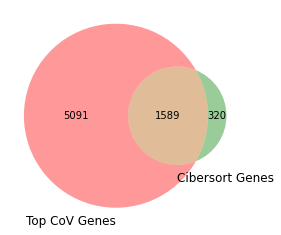

In [14]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [15]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [16]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3649 samples in 0.021s...
[t-SNE] Computed neighbors for 3649 samples in 0.954s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3649
[t-SNE] Computed conditional probabilities for sample 2000 / 3649
[t-SNE] Computed conditional probabilities for sample 3000 / 3649
[t-SNE] Computed conditional probabilities for sample 3649 / 3649
[t-SNE] Mean sigma: 1.161060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.917435
[t-SNE] KL divergence after 500 iterations: 0.947872
(3649, 2)
(3649, 2)


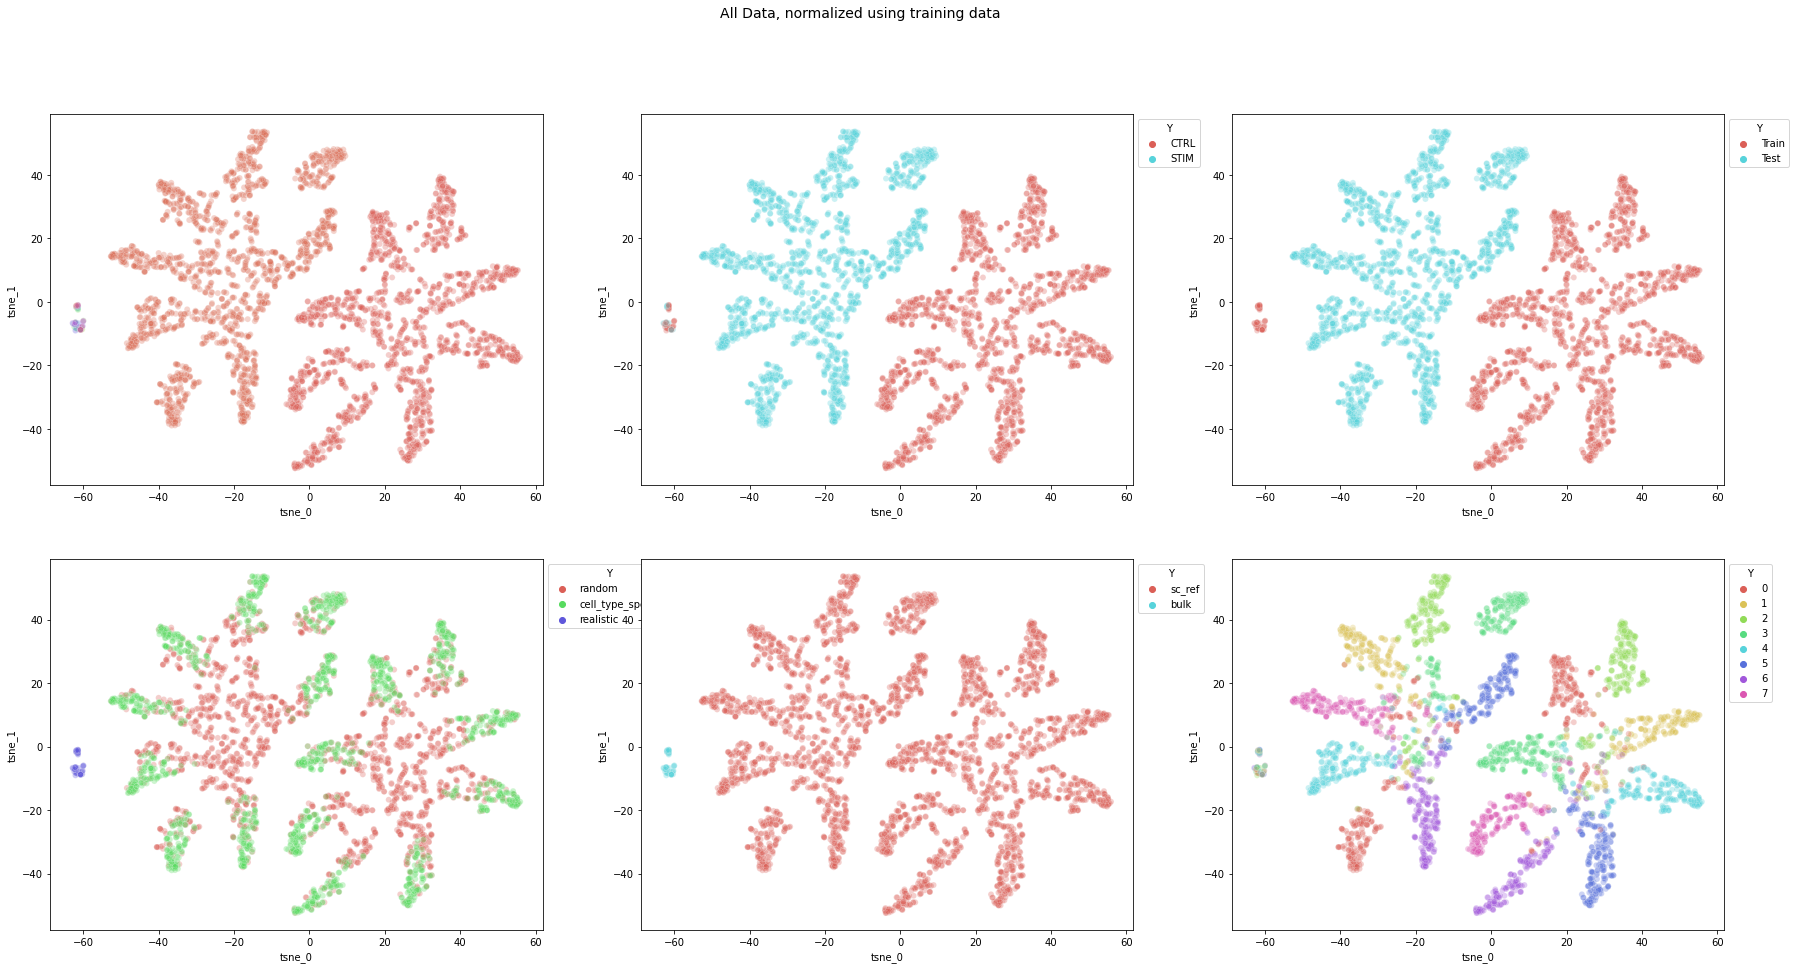

In [17]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(49, 2)
(49, 2)


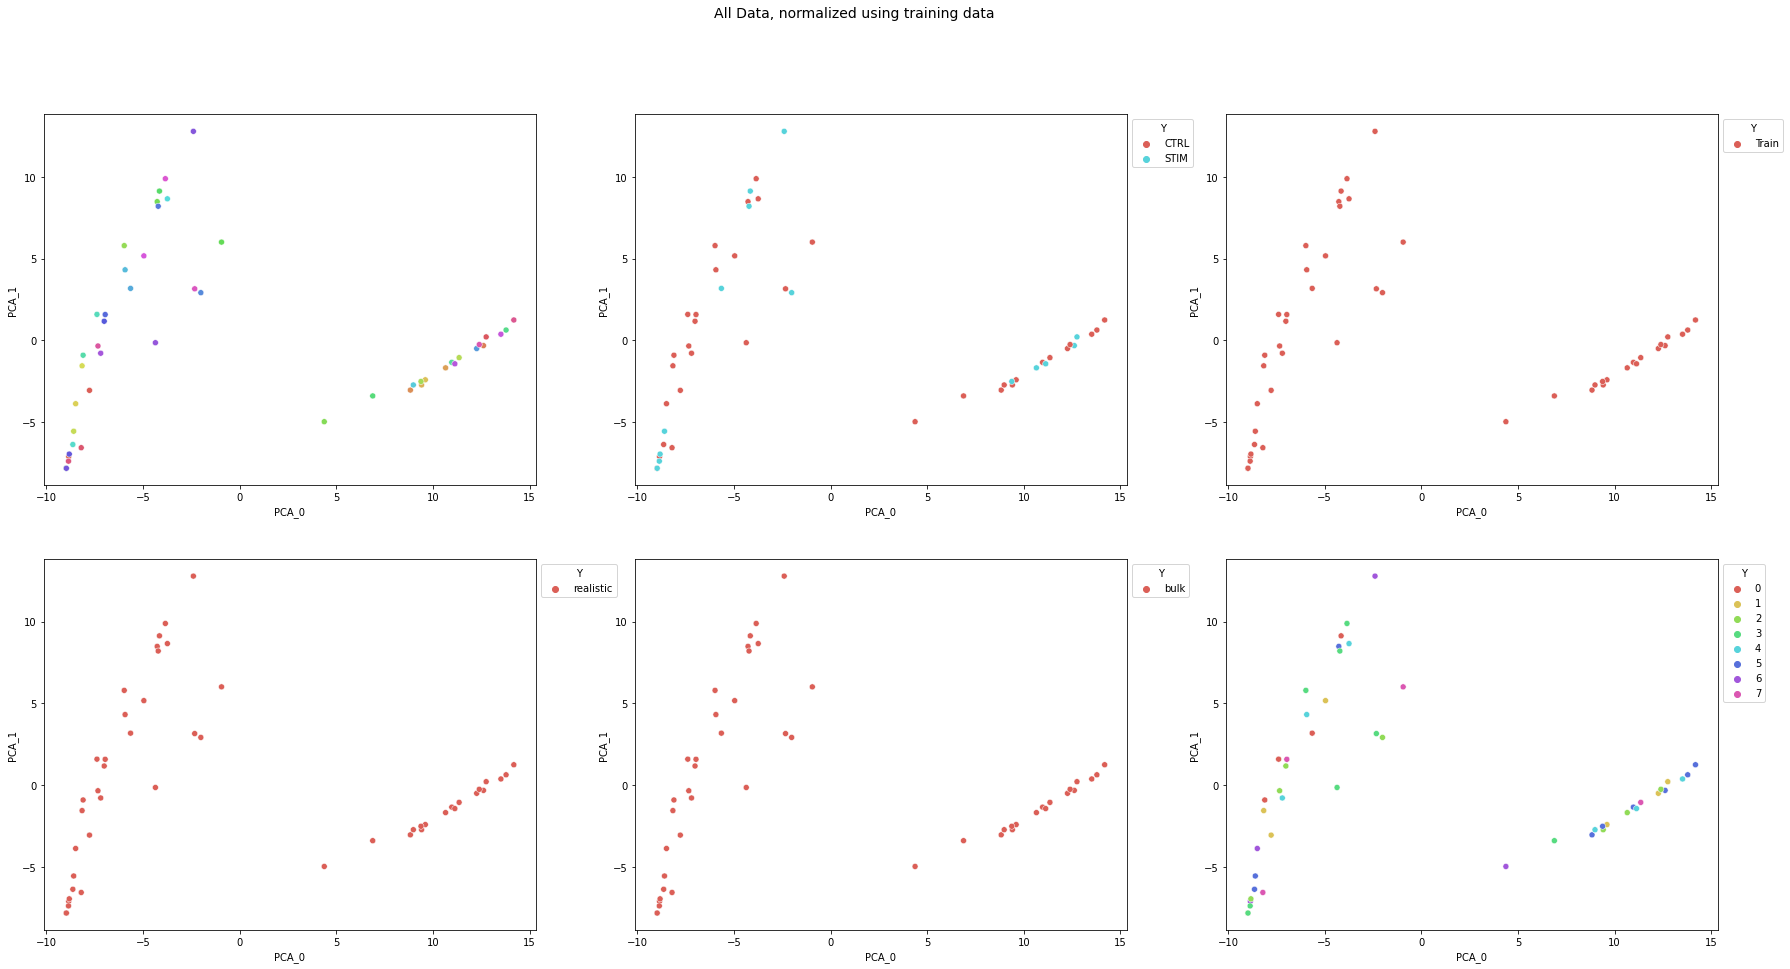

In [18]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1)
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1)


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.000s...
[t-SNE] Computed neighbors for 49 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 8.985739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.008629
[t-SNE] KL divergence after 500 iterations: 0.408980
(49, 2)
(49, 2)


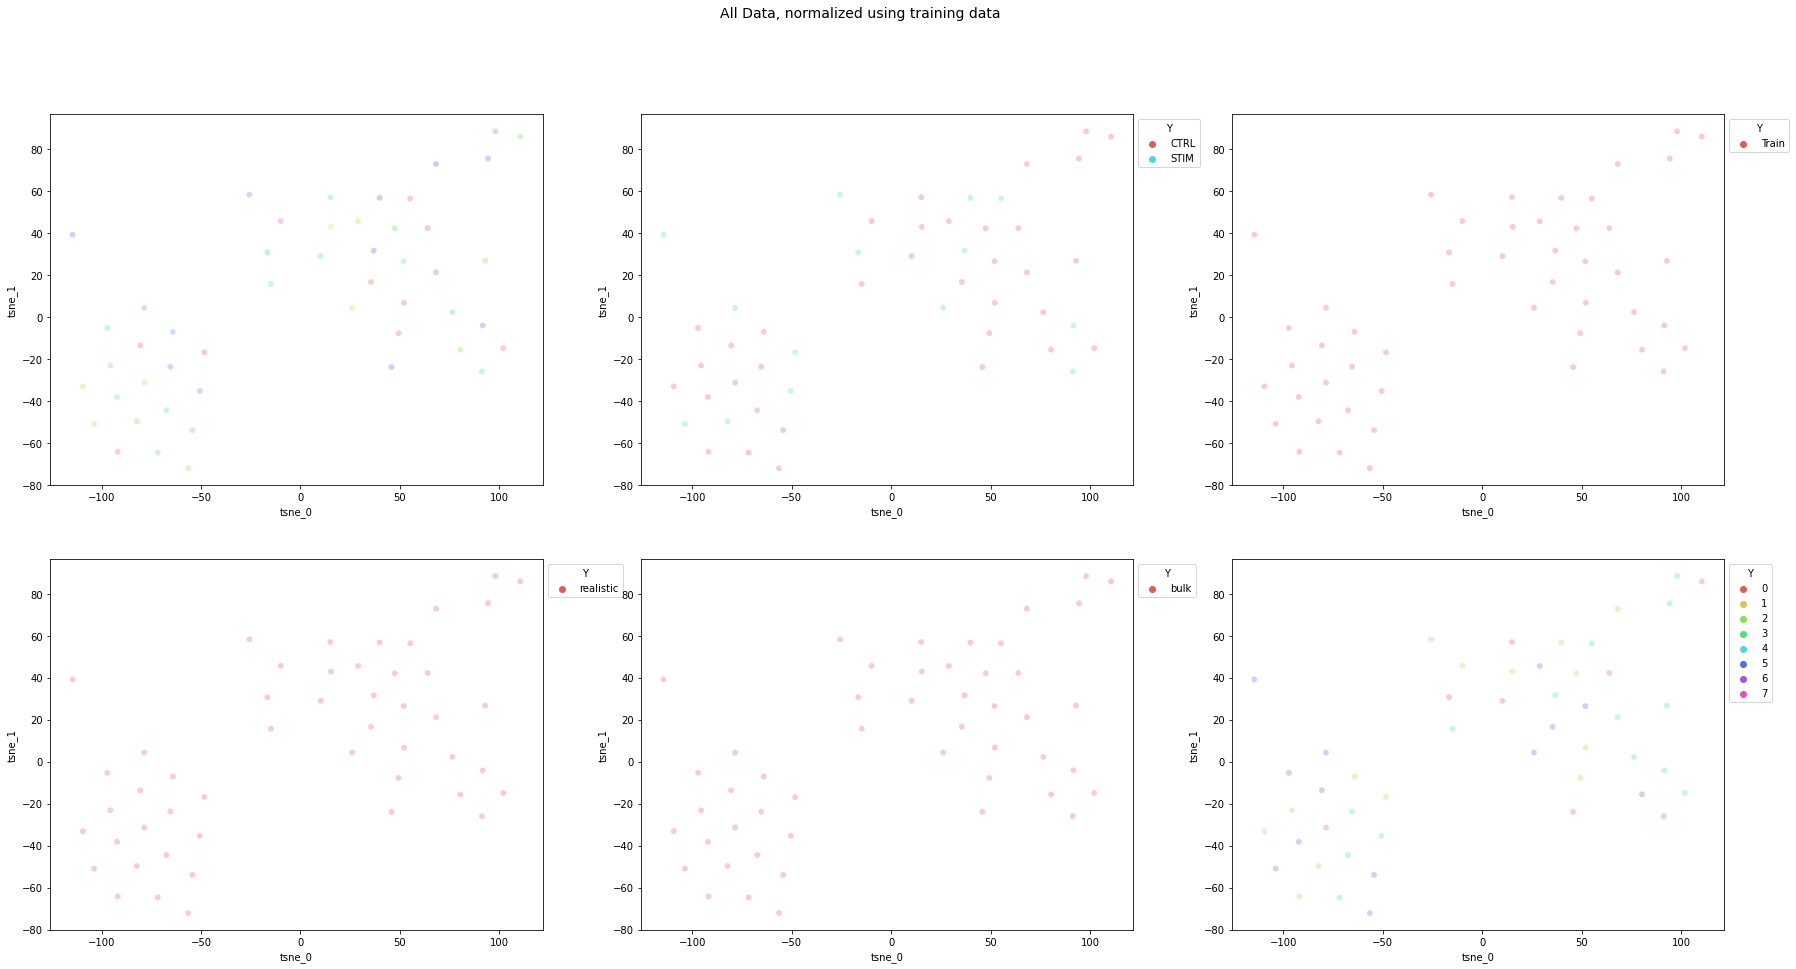

In [19]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run BuDDI**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the weighting of the loss for the latent space classifications against the reconstruction (100, 1000, 10000)
2.  the number of epochs  (50, 100, 200)

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  167.57602047920227
Epoch:  49


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_100_all-liver_classifier/assets


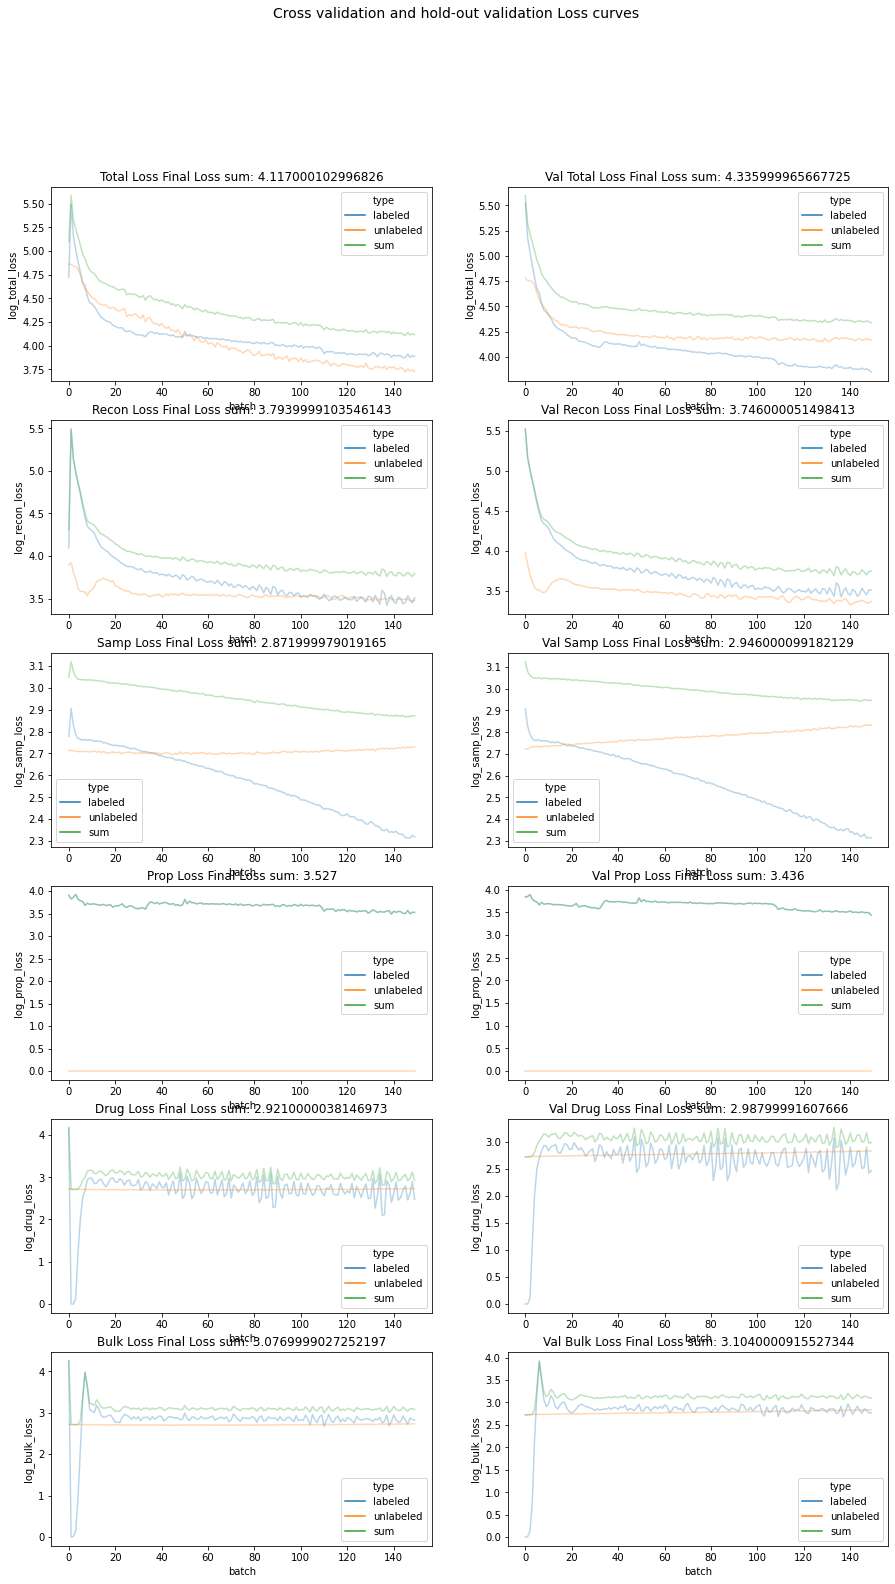

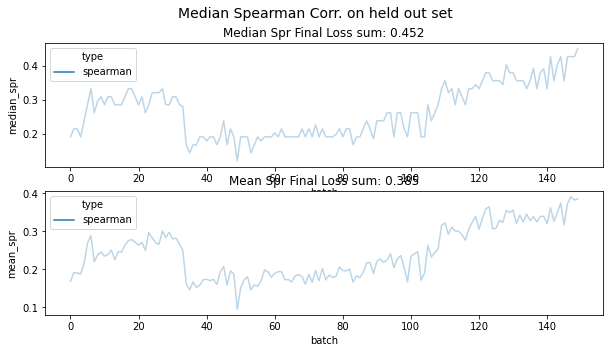

In [20]:
curr_n_epoch=50
curr_wt = 100
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 50 1000

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  168.78900957107544
Epoch:  49


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_1000_all-liver_classifier/assets


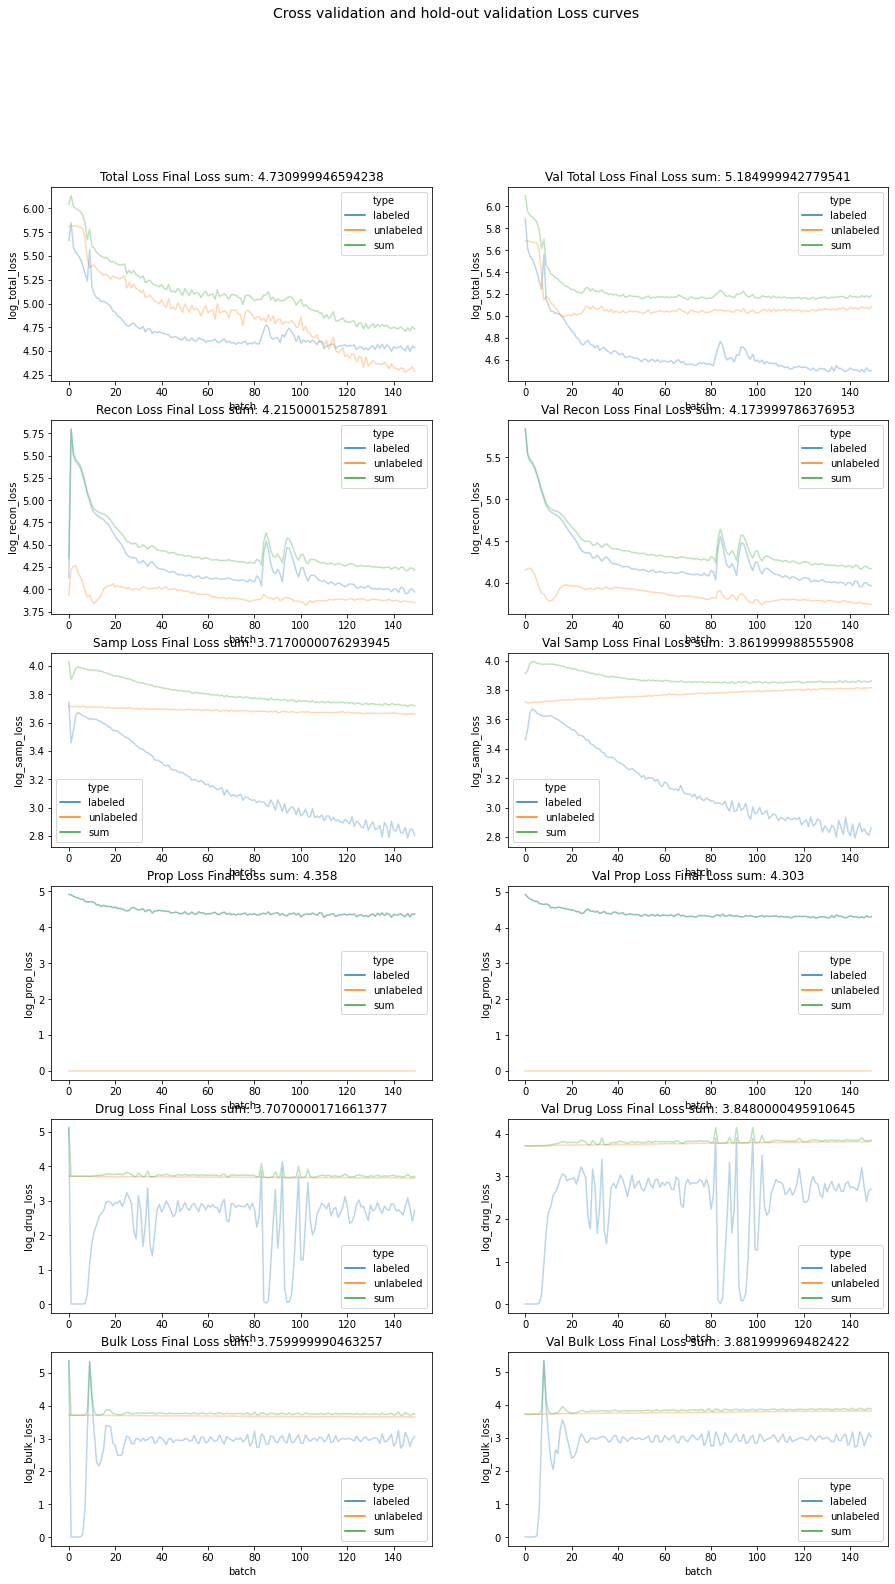

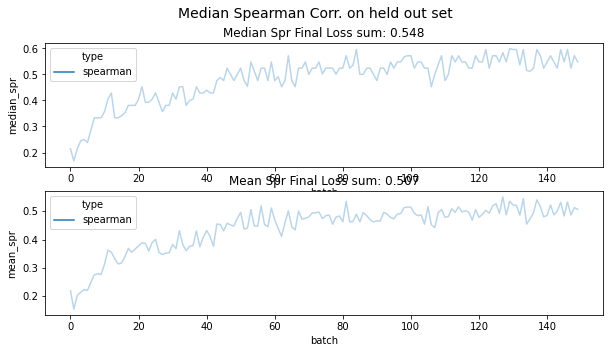

In [21]:
curr_n_epoch=50
curr_wt = 1000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 50 10000

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  169.31128025054932
Epoch:  49


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//50_10000_all-liver_classifier/assets


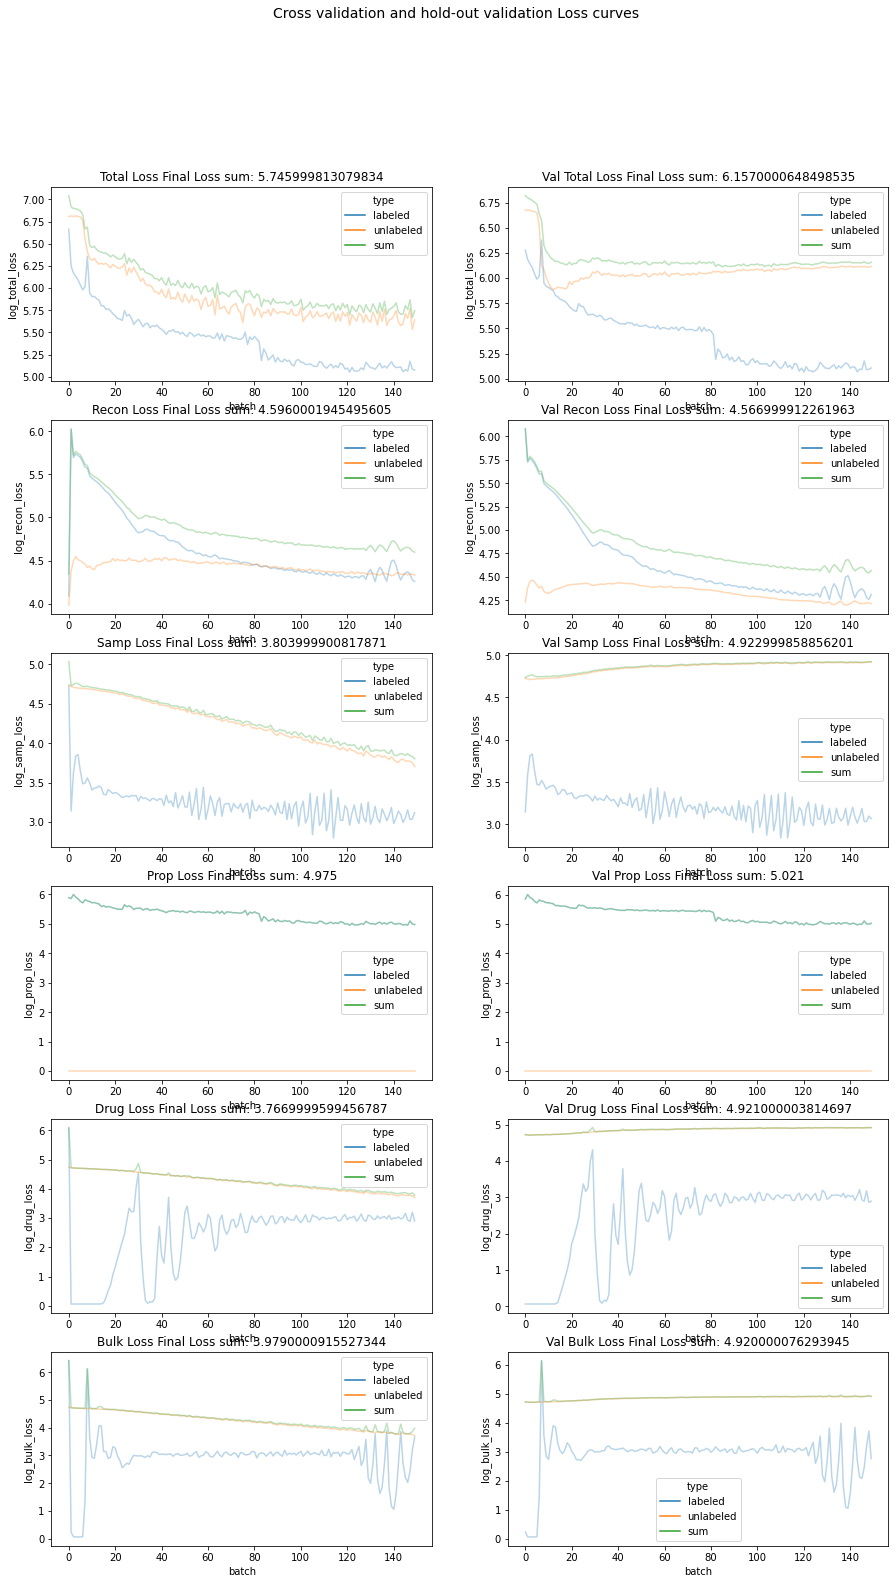

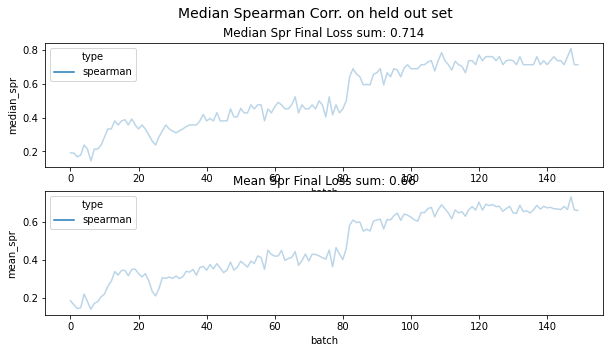

In [22]:
curr_n_epoch=50
curr_wt = 10000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 100 100

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  328.6499798297882
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_classifier/assets


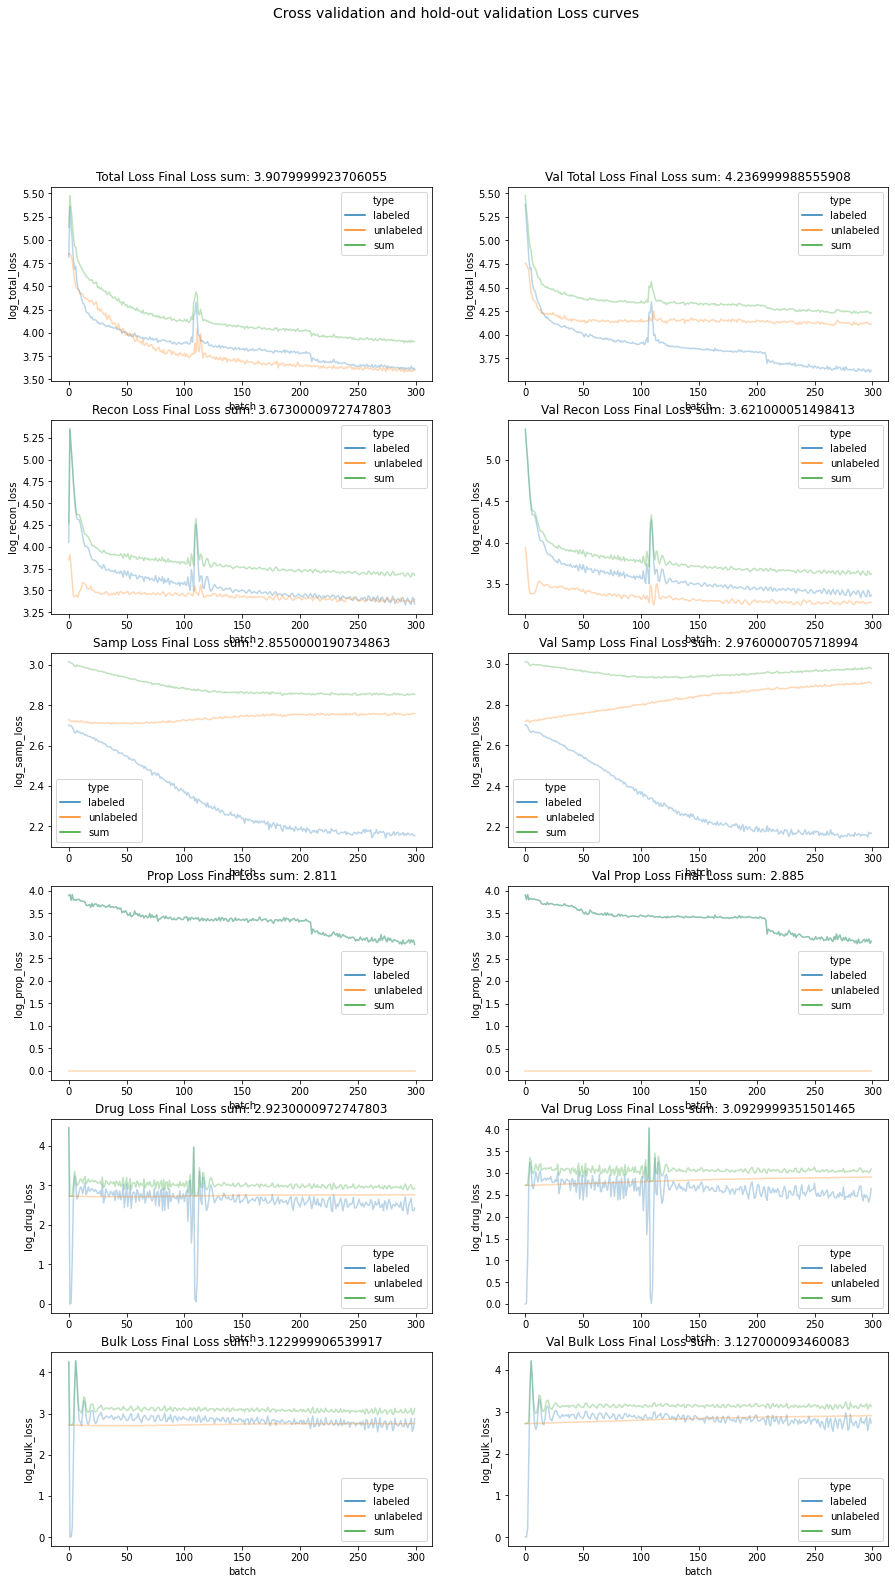

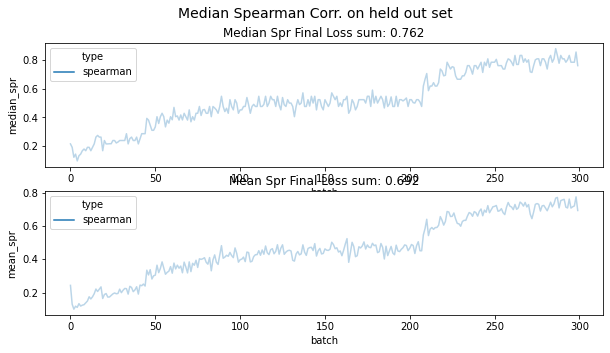

In [23]:
curr_n_epoch=100
curr_wt = 100
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 100 1000

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  334.1663658618927
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_1000_all-liver_classifier/assets


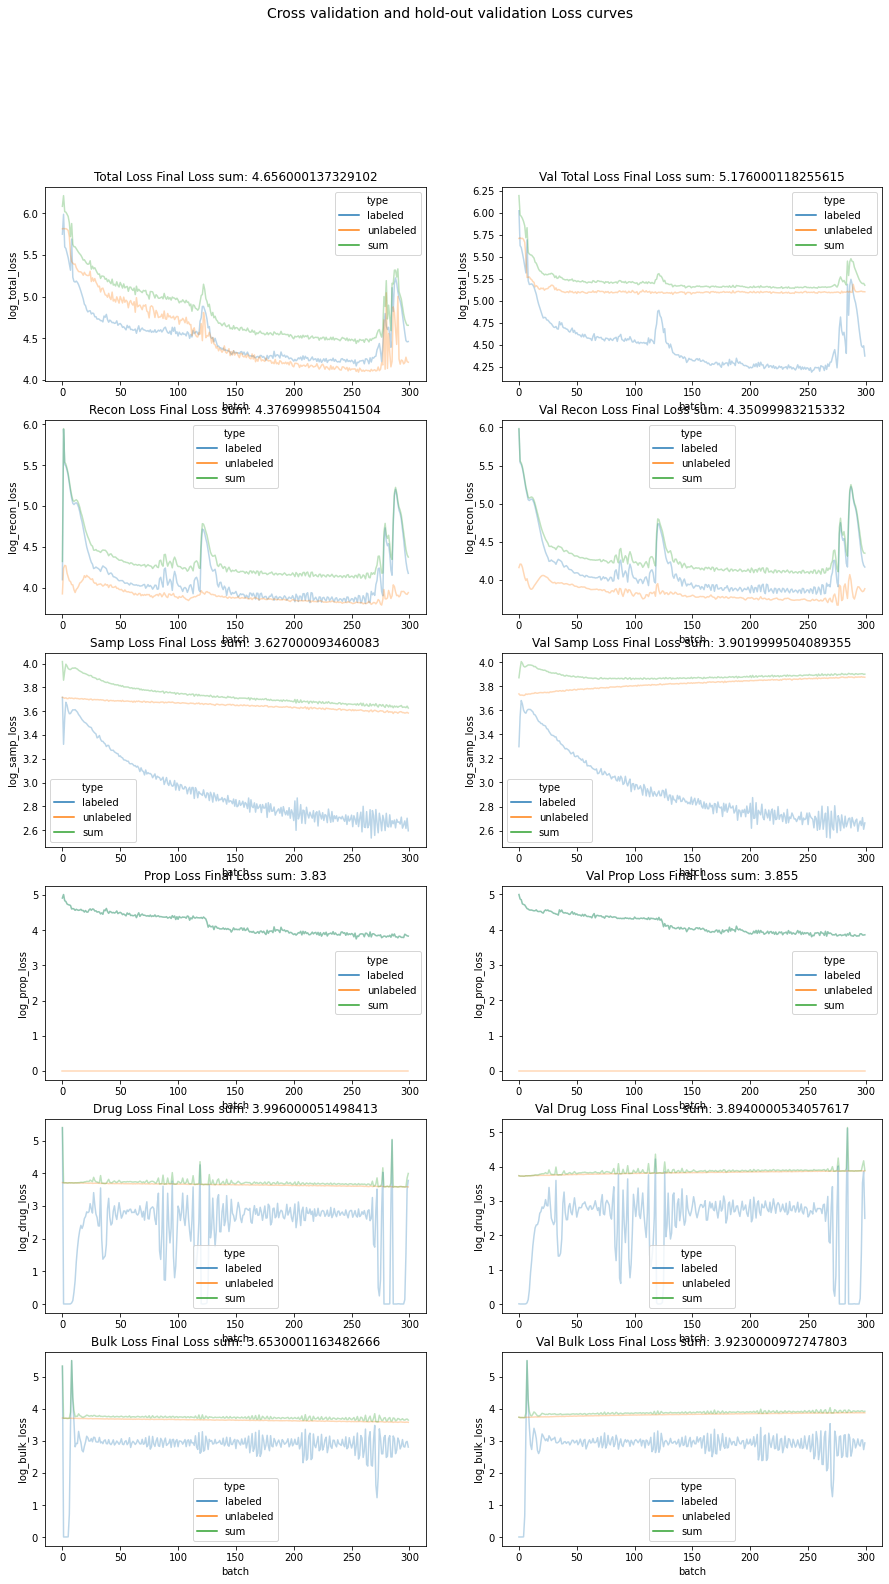

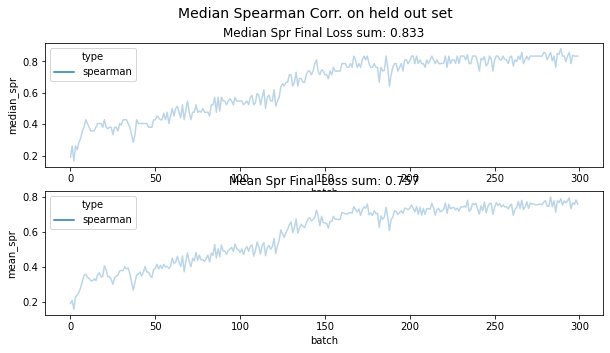

In [24]:
curr_n_epoch=100
curr_wt = 1000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 100 10000

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  340.22405195236206
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_10000_all-liver_classifier/assets


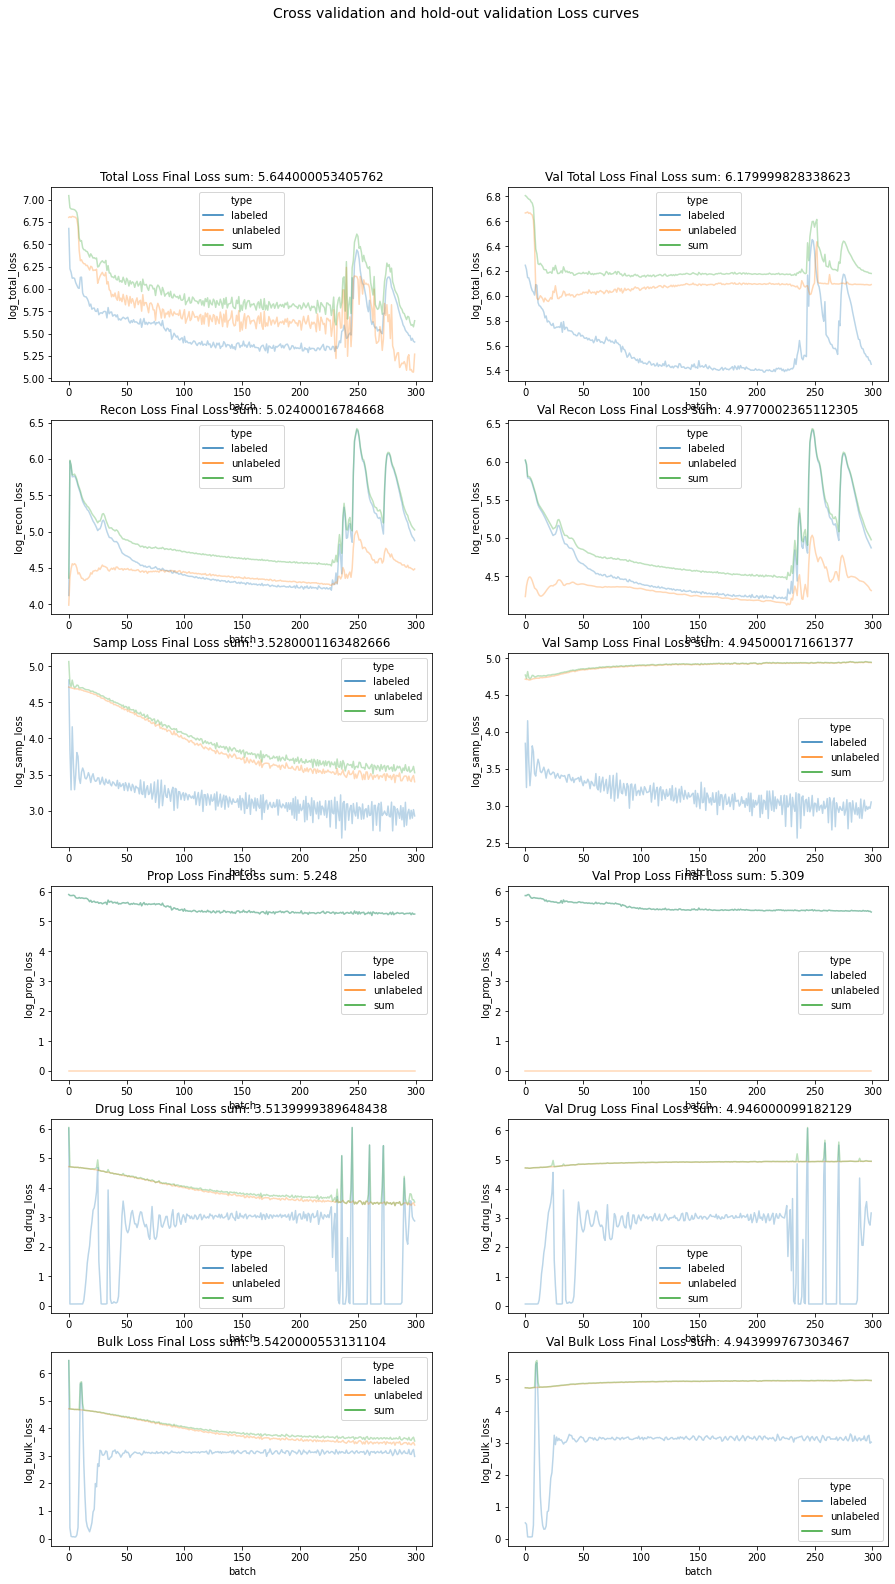

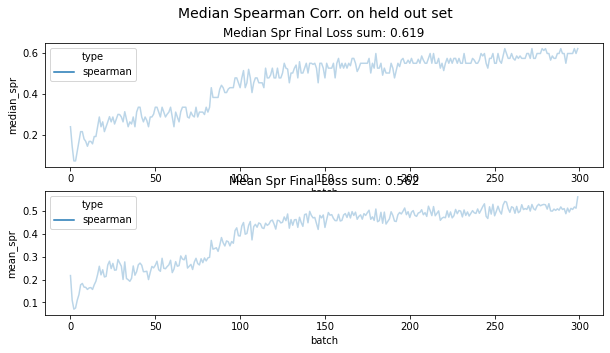

In [25]:
curr_n_epoch=100
curr_wt = 10000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 200 100

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  676.3465254306793
Epoch:  199


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_100_all-liver_classifier/assets


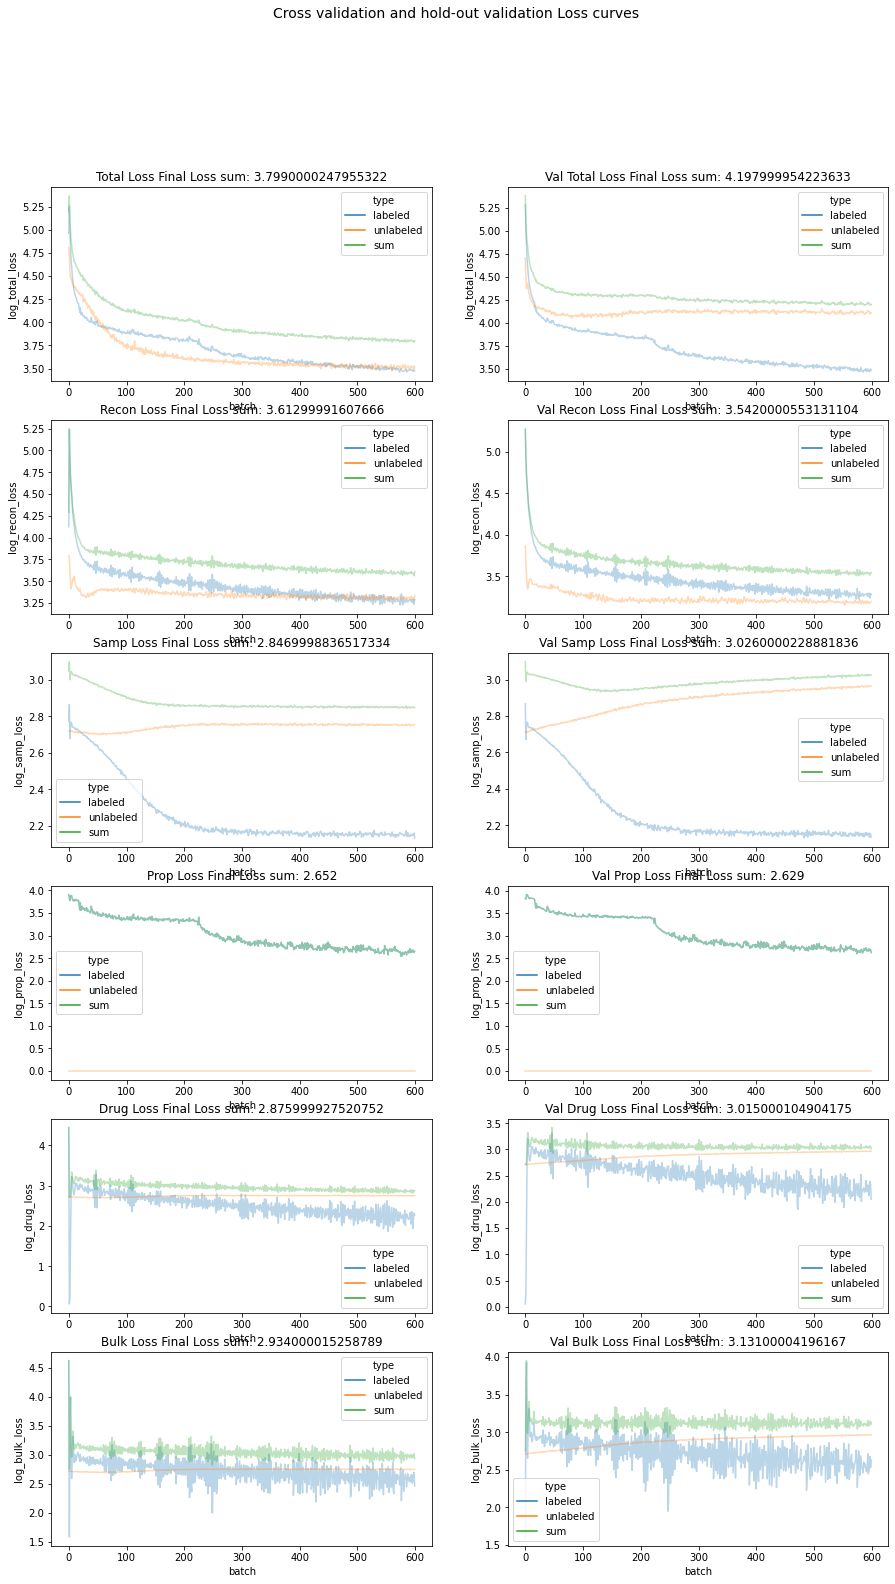

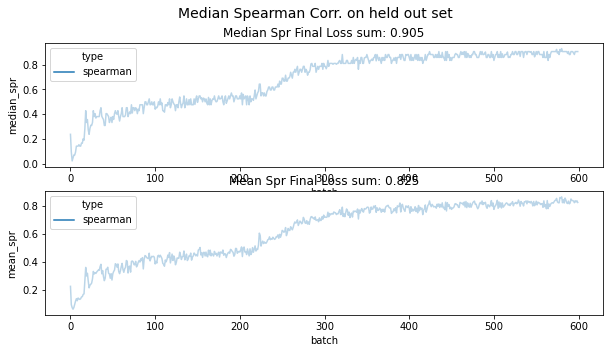

In [26]:
curr_n_epoch=200
curr_wt = 100
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 200 1000

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  343.14385509490967
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//100_100_all-liver_classifier/assets


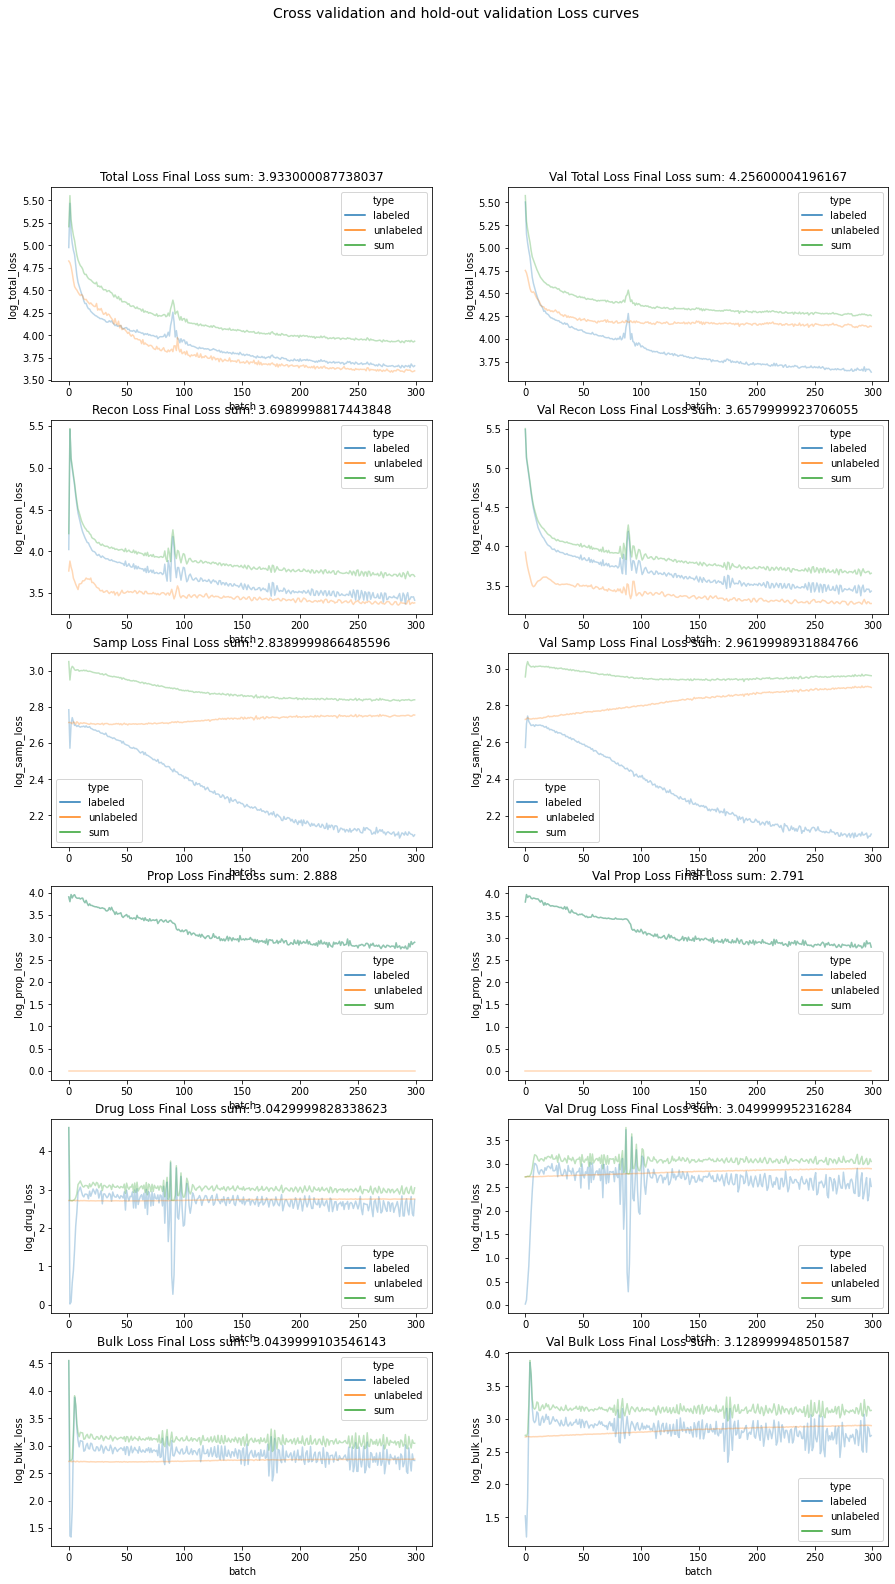

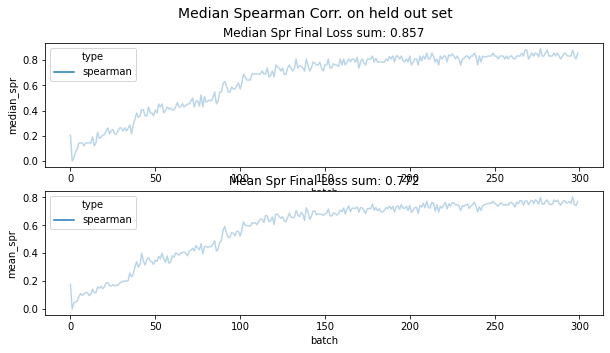

In [27]:
curr_n_epoch=200
curr_wt = 1000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 200 10000

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  710.1518082618713
Epoch:  199


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//200_10000_all-liver_classifier/assets


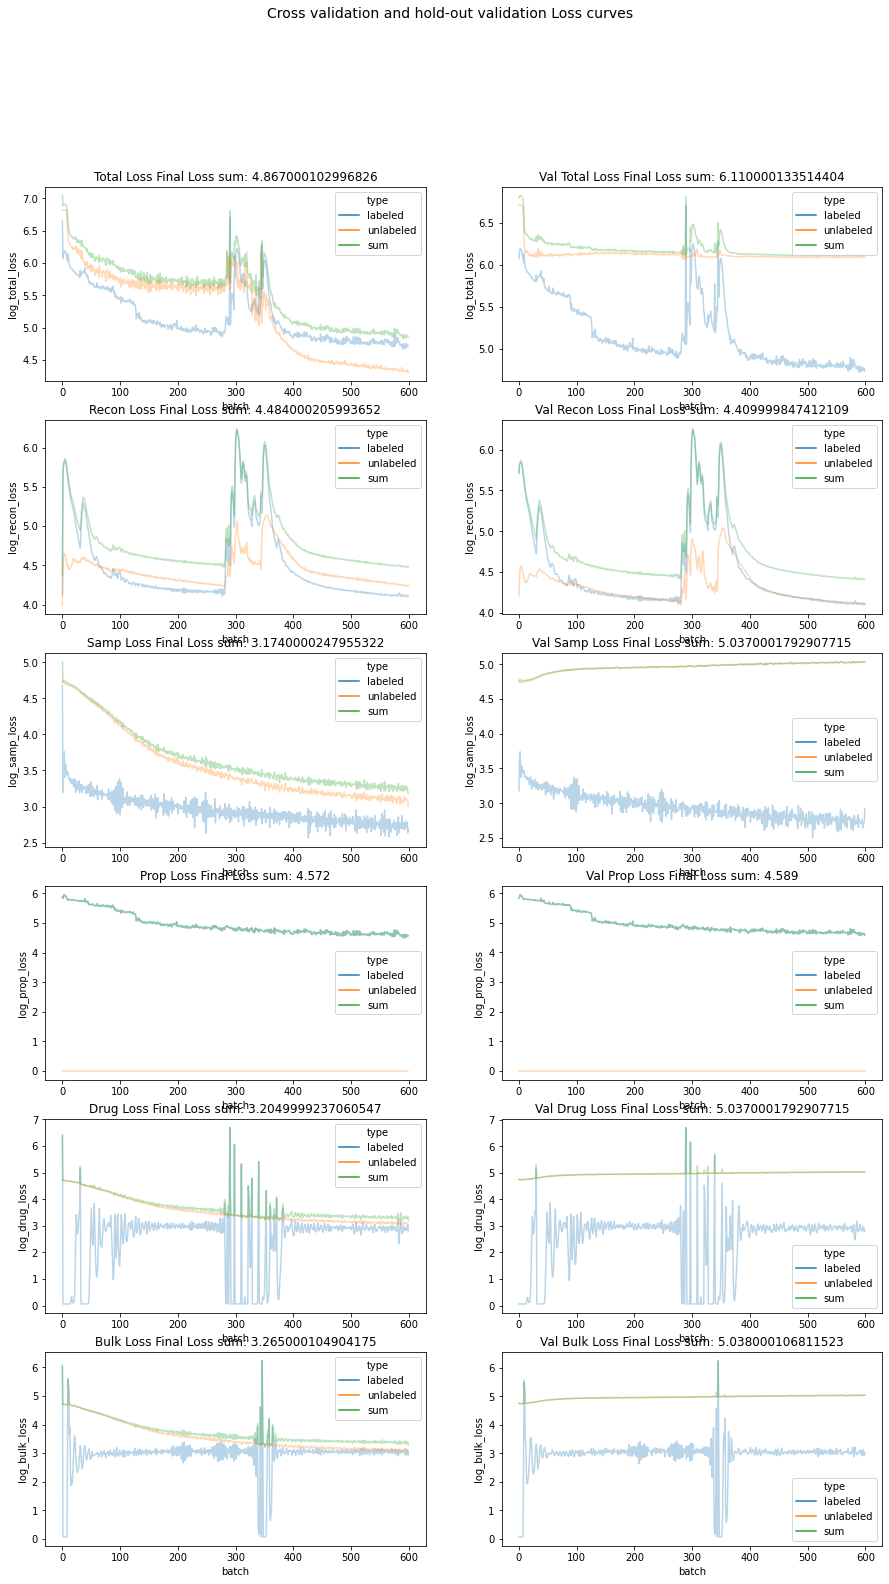

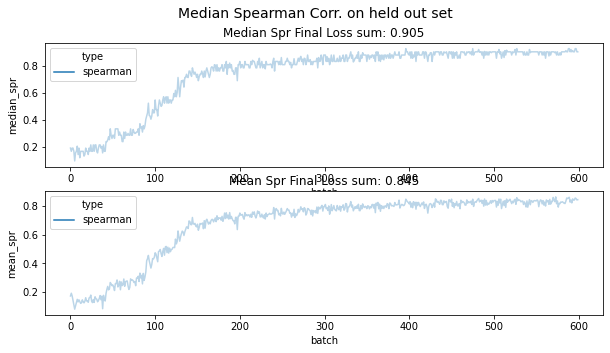

In [28]:
curr_n_epoch=200
curr_wt = 10000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

In [70]:
res

BuddiTrainResults(known_prop_vae=<keras.engine.functional.Functional object at 0x7fa3a61c39d0>, unknown_prop_vae=<keras.engine.functional.Functional object at 0x7fa3b8cdf1f0>, encoder_unlab=<keras.engine.functional.Functional object at 0x7fa3a589b0a0>, encoder_lab=<keras.engine.functional.Functional object at 0x7fa3ccb18b20>, decoder=<keras.engine.functional.Functional object at 0x7fa3ac87e6d0>, classifier=<keras.engine.functional.Functional object at 0x7fa3a694fee0>, loss_fig=<Figure size 1080x1800 with 12 Axes>, spr_fig=<Figure size 720x360 with 2 Axes>, output_folder='/beevol/home/davidson/checkouts/sc_bulk_ood/hyperparameter_search/../results/single_cell_data/buddiM2_liver/')

# **Results**

Looking at all the results, we see that XX performs the best overall, from the spearman correlation and from the validation loss. We will go forward with these hyperparameters and run them three times to get 3 different trained models that we can use for downstream validation.

test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  713.2300639152527
Epoch:  199


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model1_all-liver_classifier/assets


test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  708.6594486236572
Epoch:  199


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model2_all-liver_classifier/assets


test_size_samp: 500
train_size_samp: 1500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  707.830233335495
Epoch:  199


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../results/single_cell_data/buddiM2_liver//model3_all-liver_classifier/assets


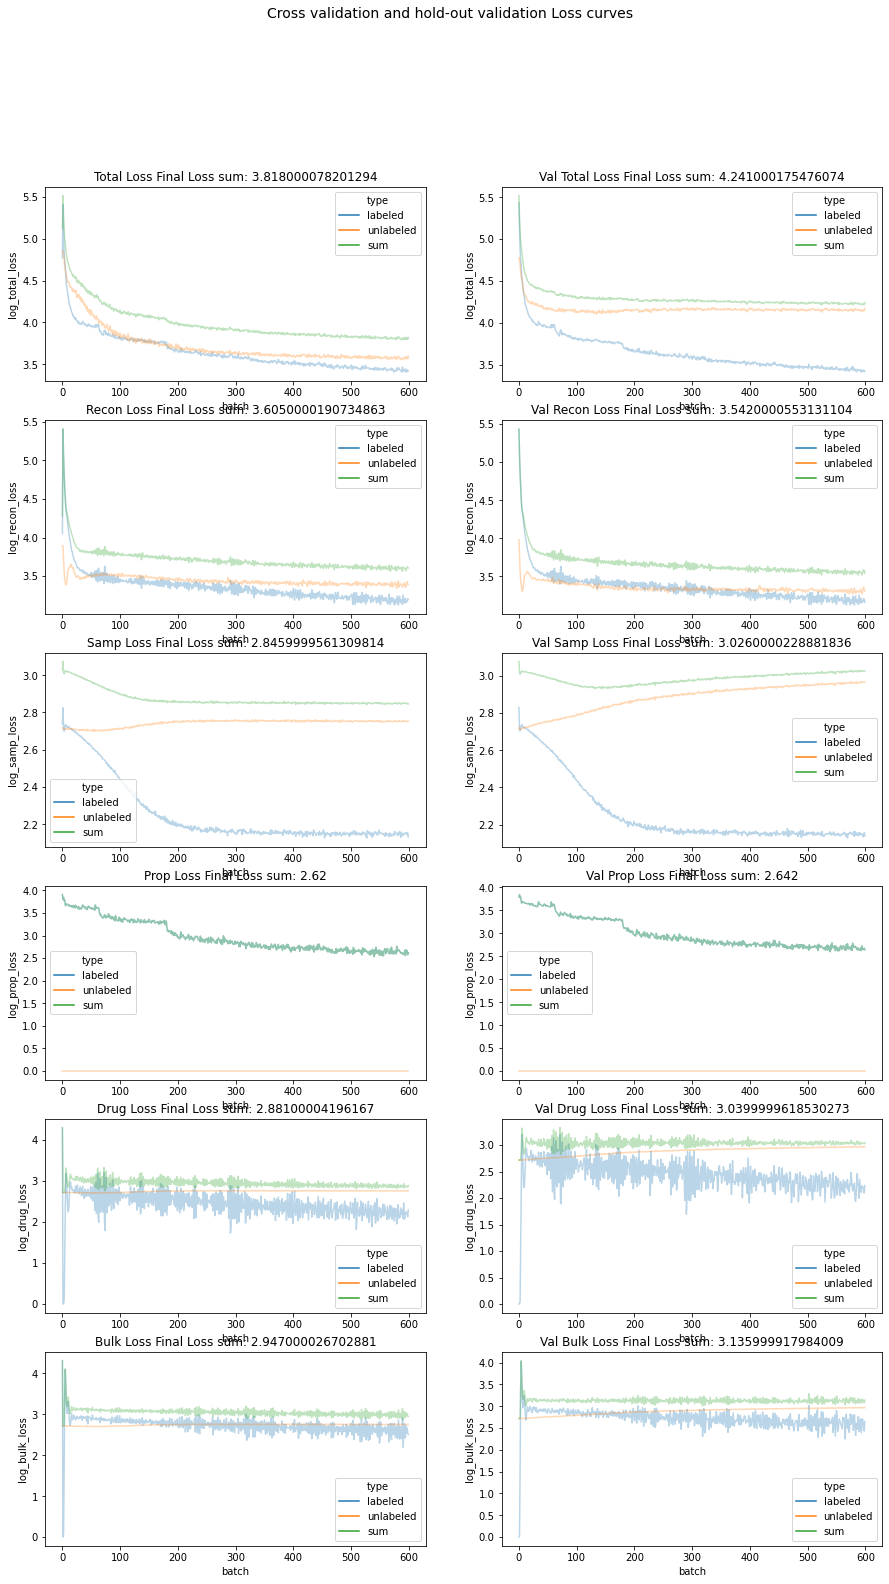

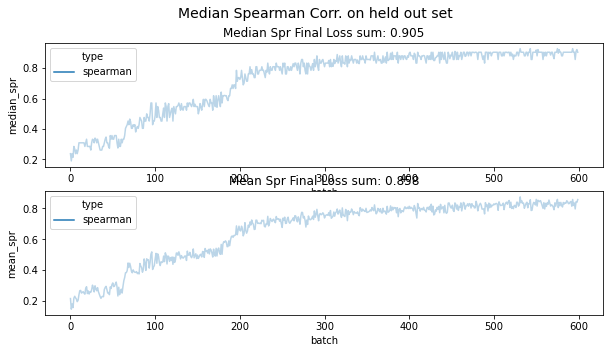

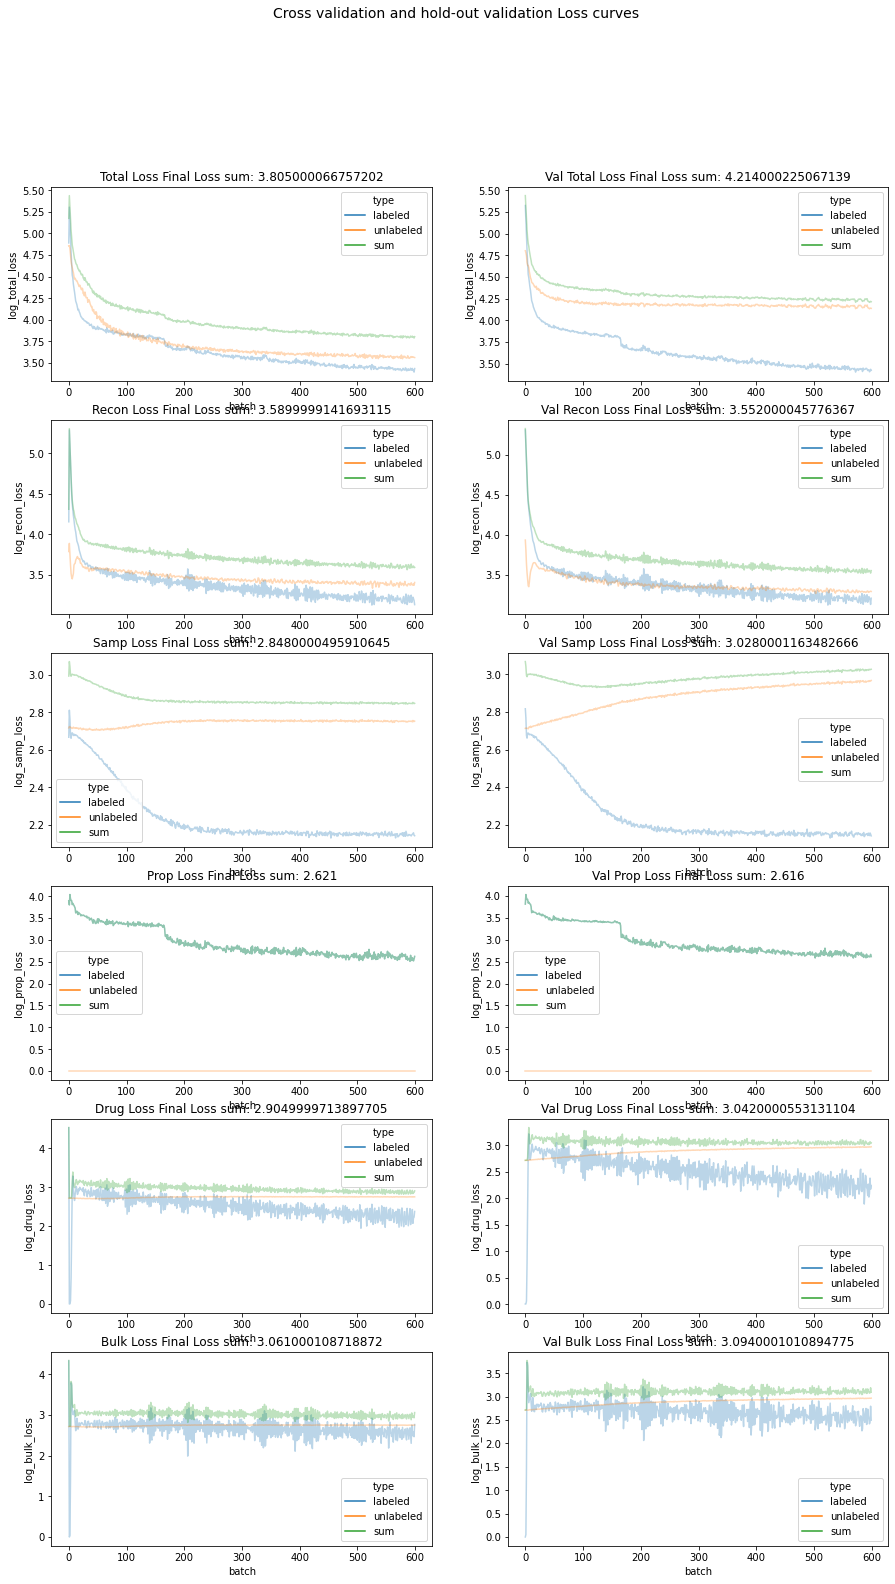

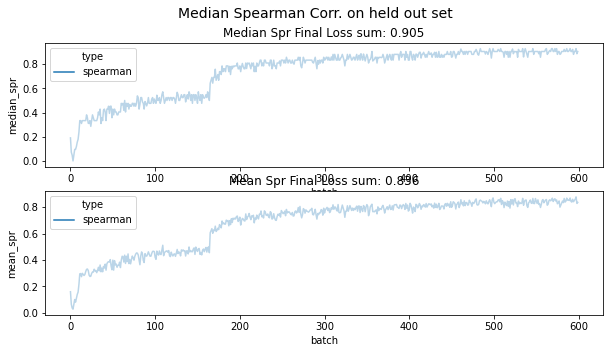

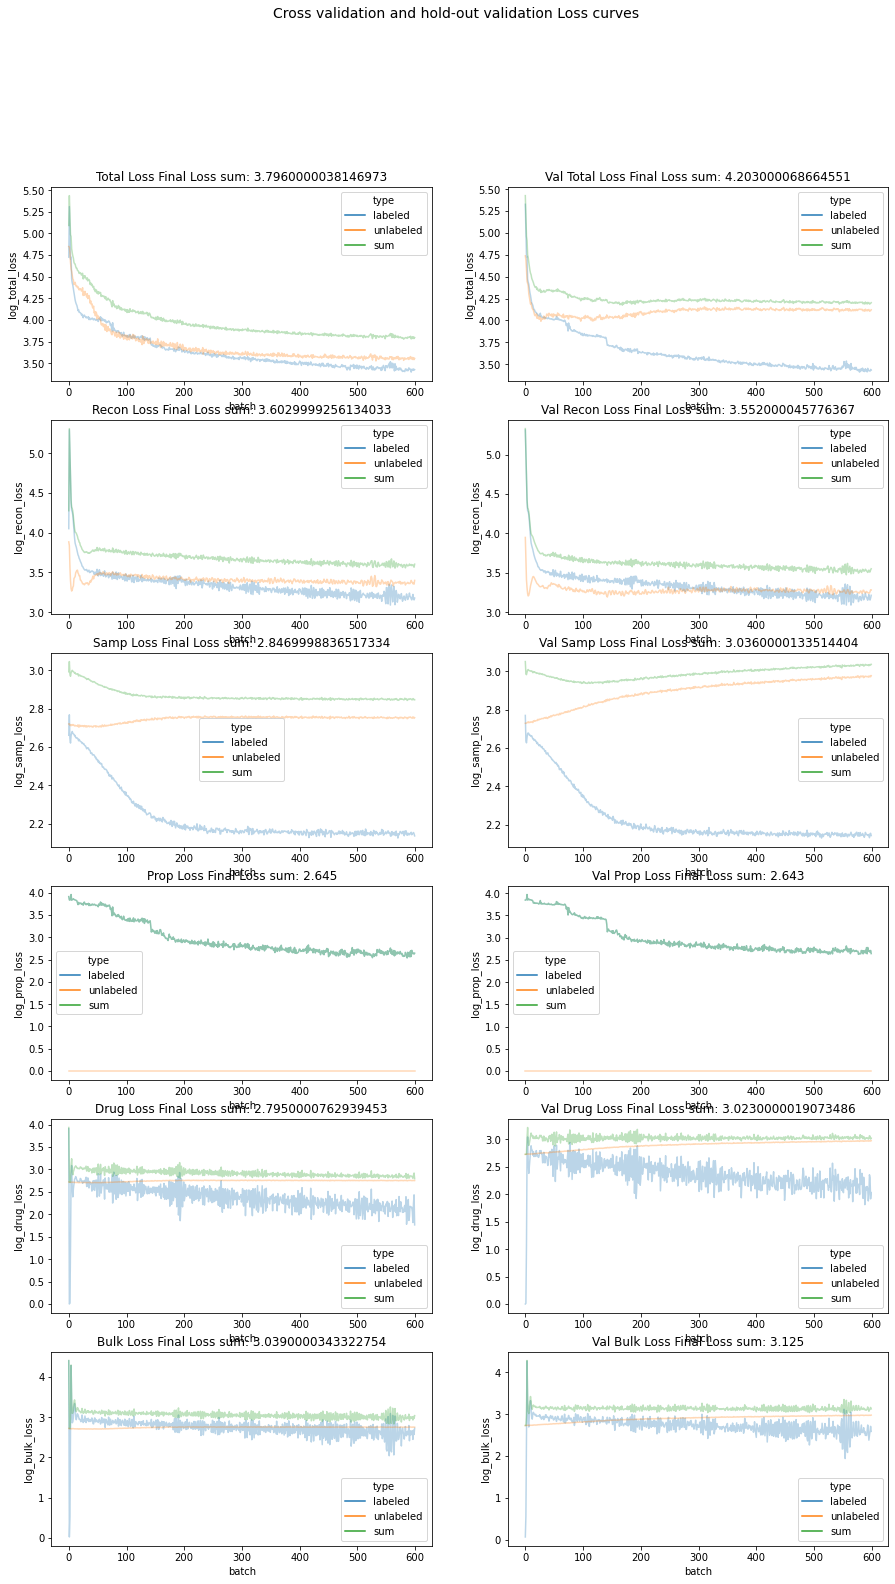

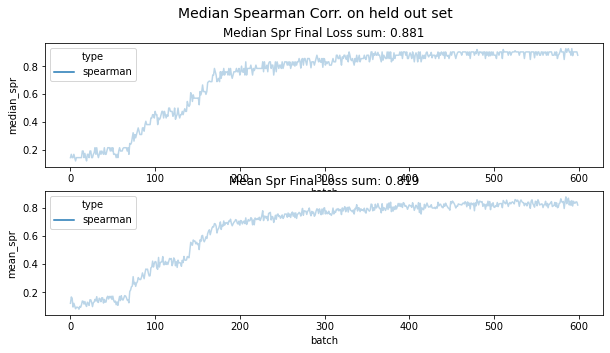

In [29]:
curr_n_epoch=200
curr_wt = 100


params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

## model 1
curr_exp_id = f"model1_{exp_id}"
res1 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

## model 2
curr_exp_id = f"model2_{exp_id}"
res2 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

## model 3
curr_exp_id = f"model3_{exp_id}"
res3 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_cell_types=n_cell_types, n_pseudobulk_rand=n_pseudobulk_rand, n_pseudobulk_ct=n_pseudobulk_ct, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)


In [30]:
from importlib import reload  # Python 3.4+
reload(buddi)
reload(buddi.buddi4)
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/../buddi/plotting/validation_plotting.py'>

## visualize latent spaces

### subset data

In [31]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp_bulk = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "realistic"))[0]
idx_tmp_bulk = np.random.choice(idx_tmp_bulk, 5000, replace=True)


idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type != "realistic"))[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)
idx_tmp = np.concatenate((idx_tmp, idx_tmp_bulk))

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


### plot data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


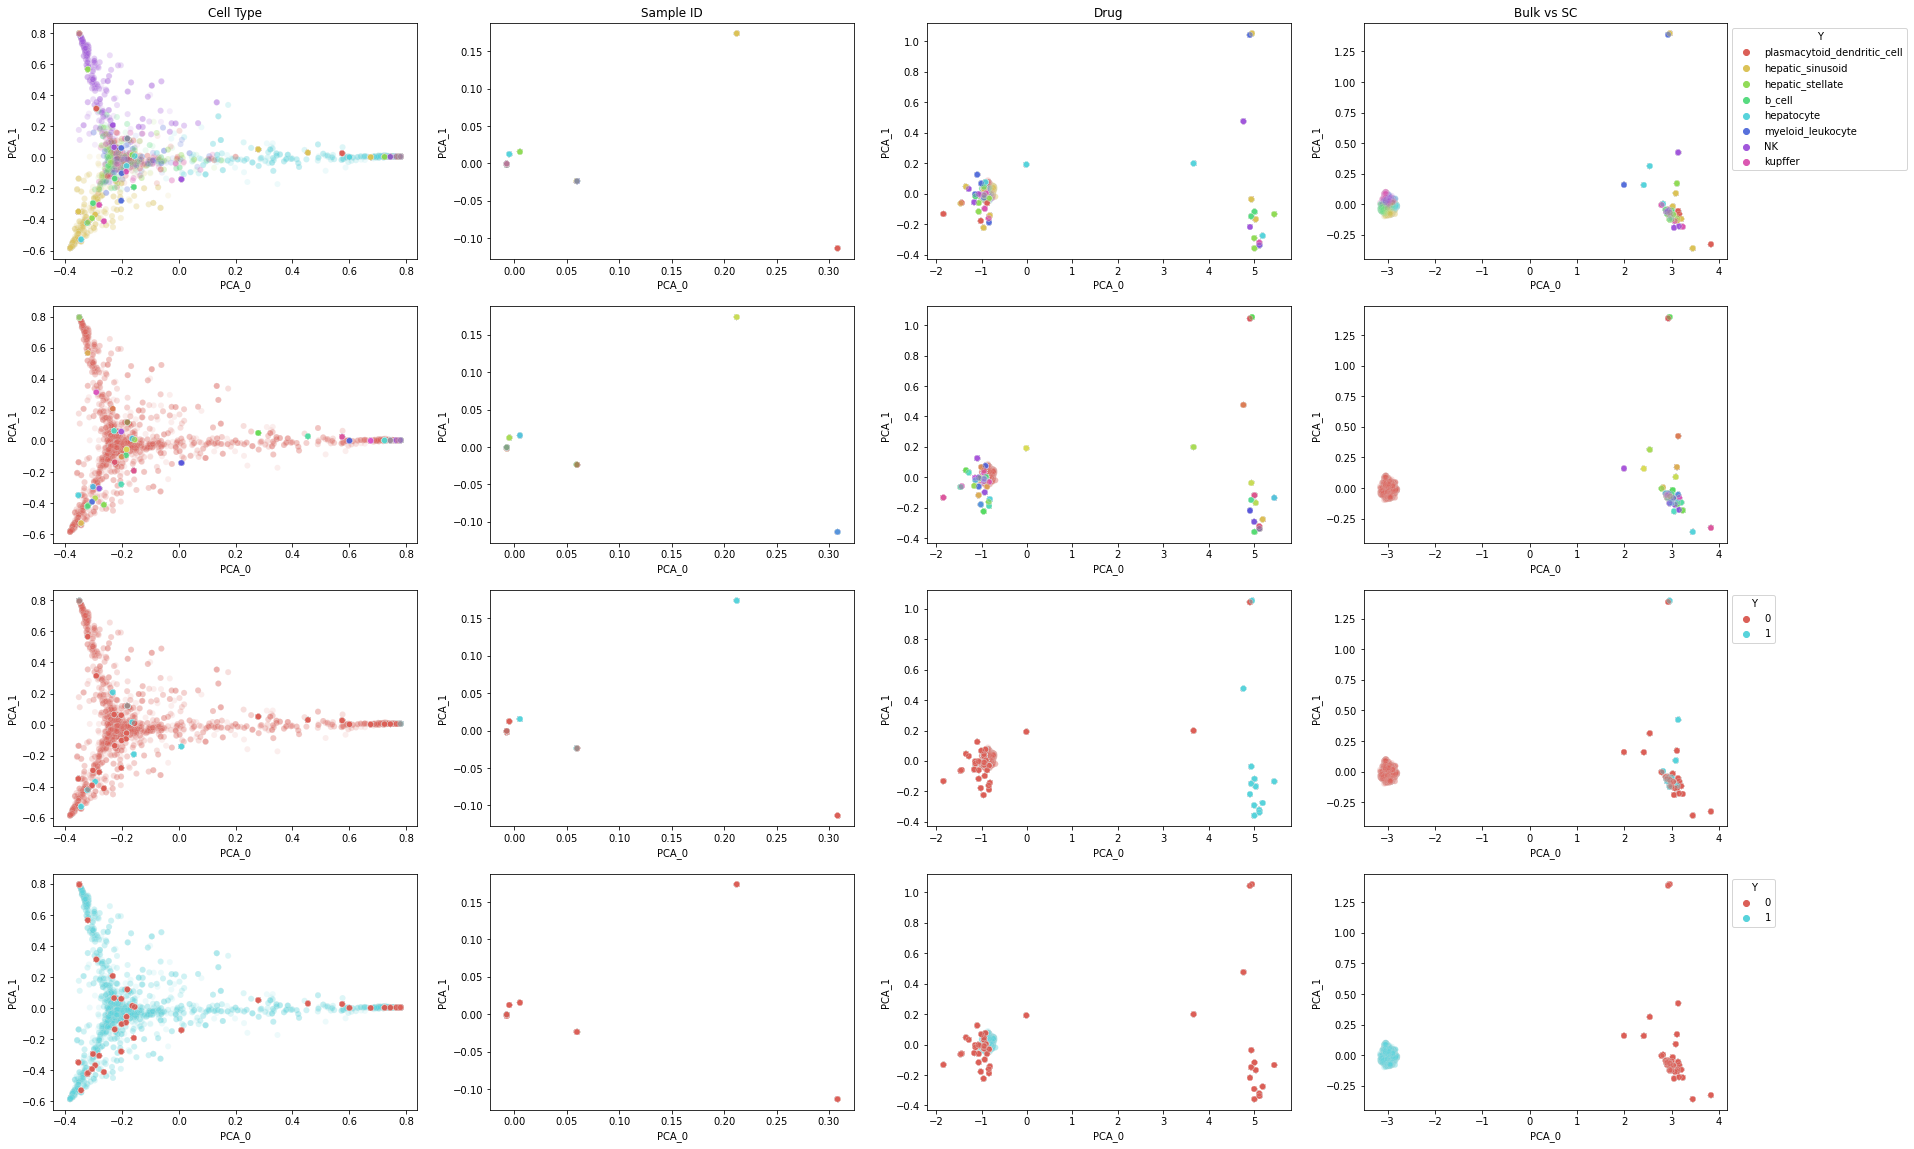

In [32]:

res1_latent_plot = buddi.plot_latent_spaces(res1.encoder_unlab, res1.classifier, res1.decoder,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


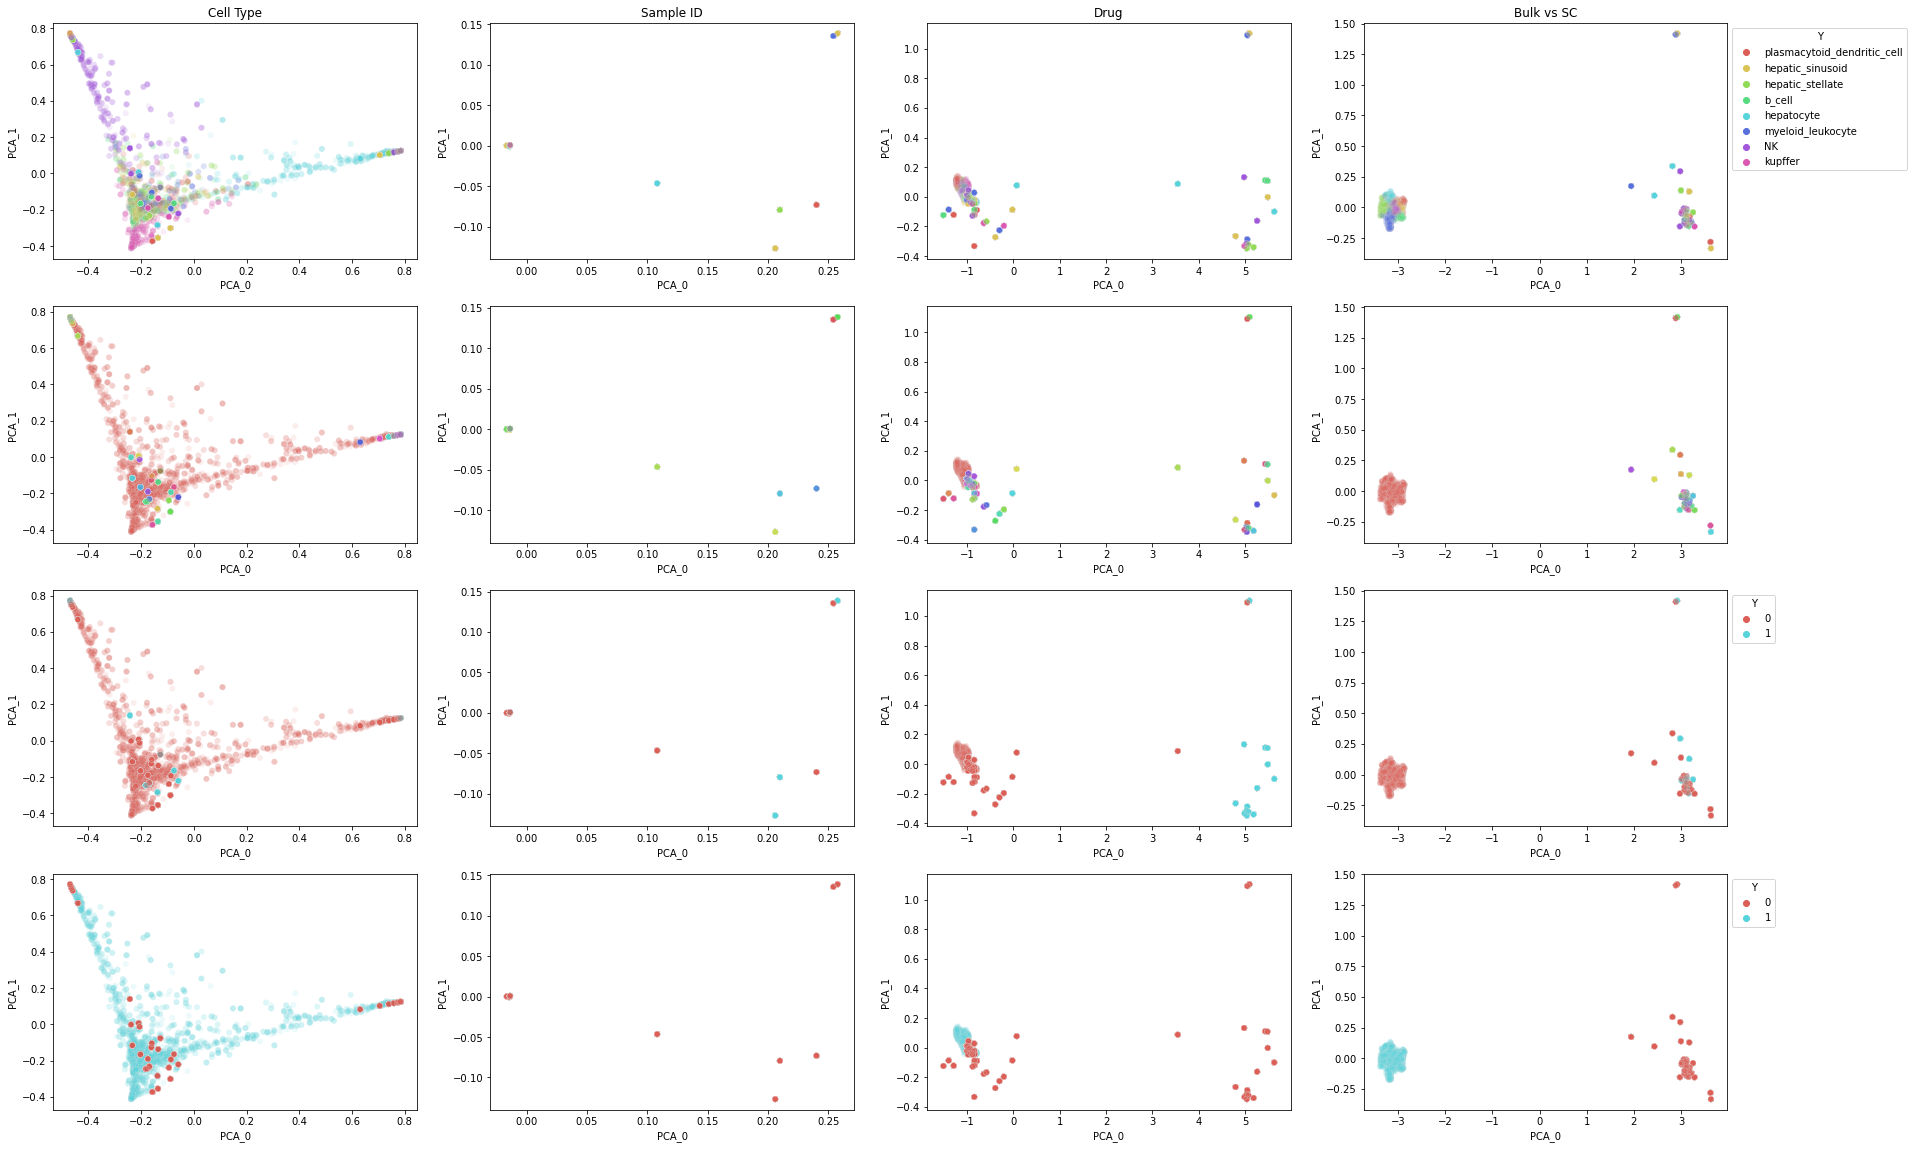

In [33]:

res2_latent_plot = buddi.plot_latent_spaces(res2.encoder_unlab, res2.classifier, res2.decoder,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


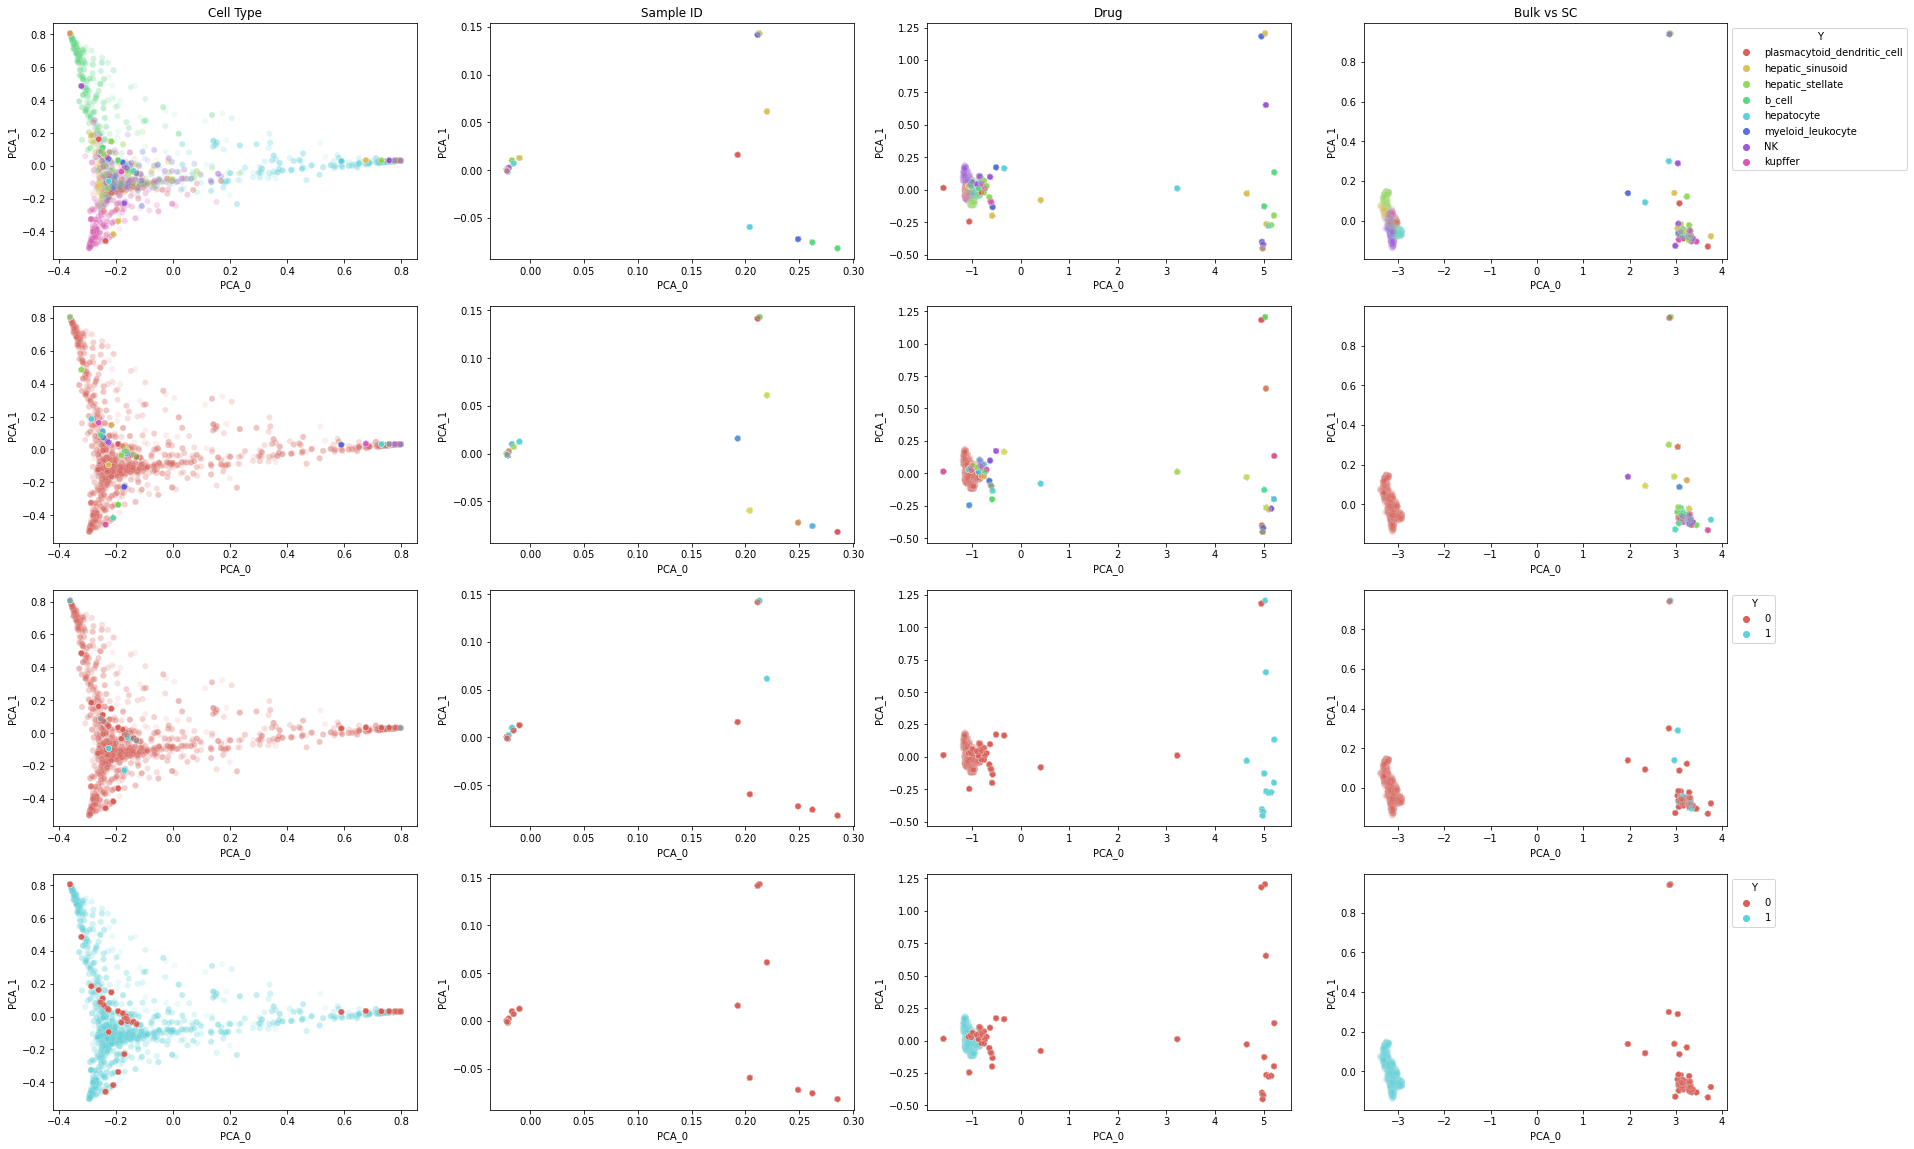

In [34]:

res3_latent_plot = buddi.plot_latent_spaces(res3.encoder_unlab, res3.classifier, res3.decoder,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

## visualize reconstruction

### subset data

In [35]:
# take all training data
recon_idx = meta_df.isTraining == "Train"
recon_idx = np.where(recon_idx)[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

# subset our data

meta_temp = meta_df.iloc[recon_idx]

X_temp = np.copy(X_full[recon_idx])

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)


label_temp = np.copy(Label_full[recon_idx])

perturb_temp = Drug_full[recon_idx]




### plot data

(10000, 2)
(10000, 2)


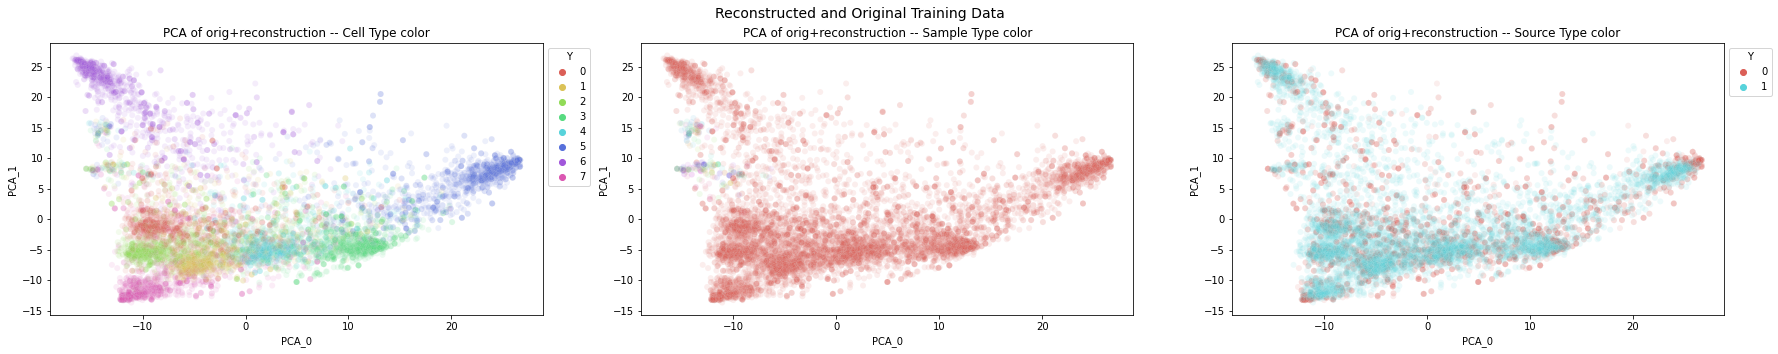

In [36]:
res1_recon_plot = buddi.plot_reconstruction_buddi(res1.encoder_unlab, res1.classifier, res1.decoder, 
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)

(10000, 2)
(10000, 2)


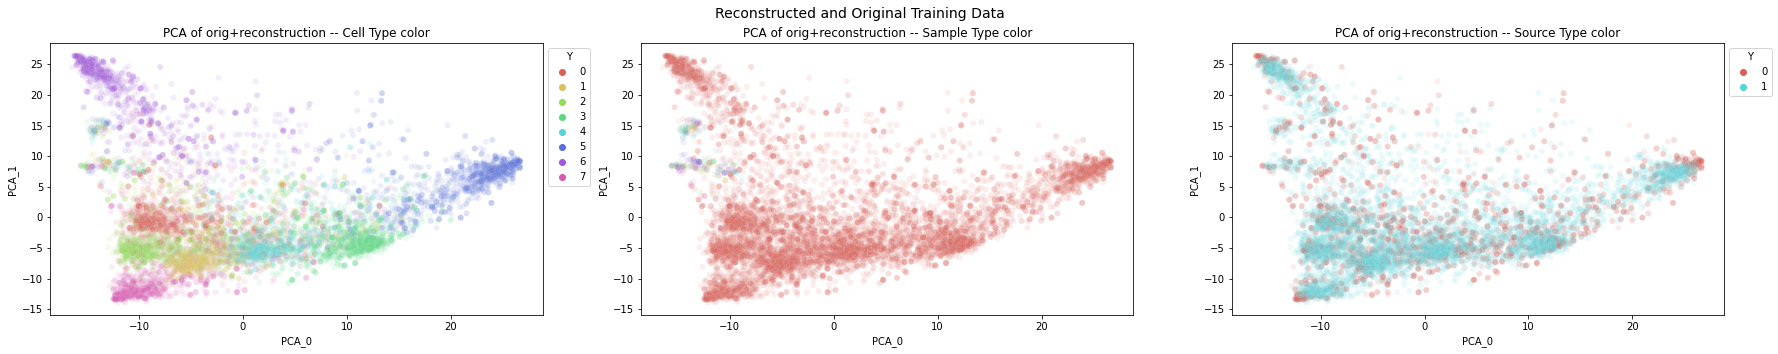

In [37]:
res2_recon_plot = buddi.plot_reconstruction_buddi(res2.encoder_unlab, res2.classifier, res2.decoder,  
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)

(10000, 2)
(10000, 2)


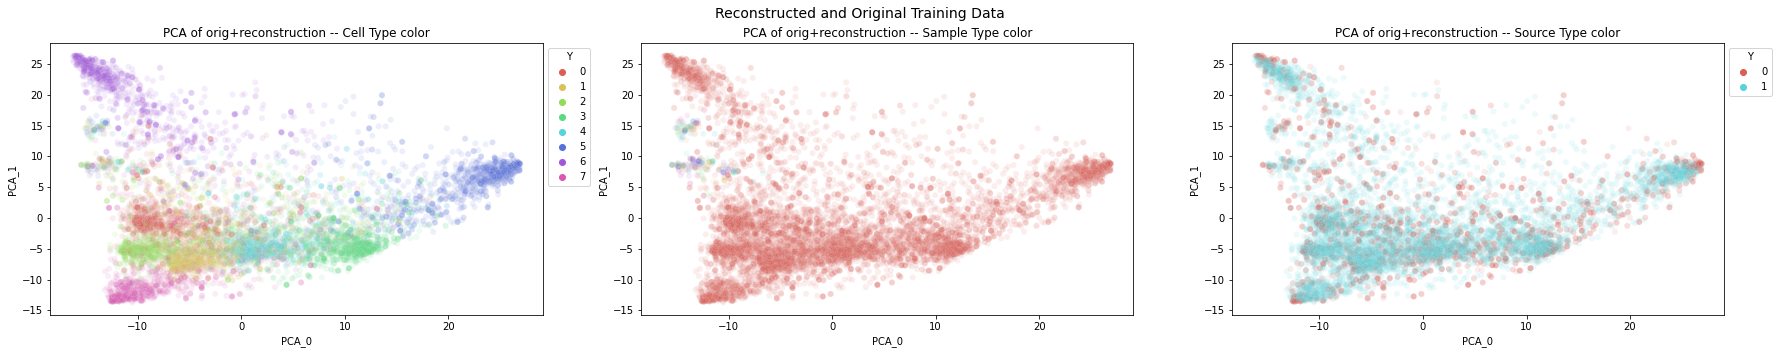

In [38]:
res3_recon_plot = buddi.plot_reconstruction_buddi(res3.encoder_unlab, res3.classifier, res3.decoder,  
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)